# Importing of packages

In [1]:
#packages
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from scipy.linalg import lstsq
from scipy.linalg import svd
import scipy.linalg

# Functions

### Sketching function

In [2]:
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

In [3]:
def optimized_sketch_matrix(m, n_columns, non_zero_entries):
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    
    # Create an m x n_columns matrix of random values
    rand_vals = np.random.rand(m, n_columns)
    # For each column, get the indices of the non_zero_entries smallest values.
    # This effectively gives us non_zero_entries unique indices per column without a full sort.
    indices = np.argpartition(rand_vals, non_zero_entries, axis=0)[:non_zero_entries, :]
    
    # Generate random ±1 values for each nonzero entry and apply scaling
    signs = np.random.choice([1, -1], size=(non_zero_entries, n_columns)) * scaling_factor
    
    # Create a matrix of column indices corresponding to each selected row index
    cols = np.tile(np.arange(n_columns), (non_zero_entries, 1))
    
    # Assign the values in one vectorized step
    S[indices, cols] = signs
    
    return S

In [4]:
def fast_sketch_matrix(m, n_columns):
    row_indices = np.random.randint(0, m, size=n_columns)  # Pick one random row per column
    col_indices = np.arange(n_columns)  # Each column gets one entry
    values = np.random.choice([1, -1], size=n_columns)  # ±1 values

    # Directly construct the sparse matrix
    S = csr_matrix((values, (row_indices, col_indices)), shape=(m, n_columns))

    return S

Optimised has memory issue

### Compute min max svd to be used for analysis

In [5]:
def compute_min_max_svd(matrix):
    # SVD computation only keep the singular values
    _, s, _ = np.linalg.svd(matrix, full_matrices=False)
    return np.min(s), np.max(s)



### Sketched least squares

In [6]:
#Higher leverage scores indicate more influential data points.
def estimate_leverage_scores(A, R, gamma):
    n, d = A.shape
    k = int(np.ceil(d / gamma))  # Choose k based on γ
    G = np.random.randn(d, k) / np.sqrt(k) #scale the matrix
    ARG = A @ (R @ G)
    leverage_scores = np.sum(ARG ** 2, axis=1)
    
    return leverage_scores

def true_leverage_scores(A):
    U, _, _ = np.linalg.svd(A, full_matrices=False)
    return np.sum(U**2, axis=1)

def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Parameters:
    - A: Data
    - b: label
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd, max_svd = compute_min_max_svd(SA)

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x , min_svd , max_svd

## Sketched least square accounting for intercept

In [7]:
def fast_least_squares_sgd_with_intercept(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Parameters:
    - A: Data
    - b: label
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept
    
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd, max_svd = compute_min_max_svd(SA)

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x[1:],x[0], min_svd , max_svd

## Regularized sketching function accounting for intercept

In [8]:
def compute_effective_dimension(A, lambda_reg):
    """Computes the lambda-effective dimension d_lambda."""
    d = A.shape[1]
    I = np.eye(d)
    return np.trace(A.T @ A @ np.linalg.inv(A.T @ A + lambda_reg * I))

def fast_least_squares_sgd_regularized_with_intercept(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Implements fast least squares using mini-batch SGD with scaled regularization.

    Parameters:
    - A: (n, d) NumPy array (design matrix).
    - b: (n,) NumPy array (target vector).
    - lambda_reg: Regularization parameter λ.
    - m: Sketching matrix size.
    
    Returns:
    - x: (d,) NumPy array (estimated solution).
    """
   
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept 
    d += 1

    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd, max_svd = compute_min_max_svd(SA)

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x[1:],x[0] , lambda_scaled, min_svd , max_svd

## Modified functions for analysis

### Sketched SGD

In [9]:
def fast_least_squares_sgd_analysis(A, b, m, T=1000, eta=0.1, gamma=0.1, batch_size=100):
    start_total_time = time.perf_counter()
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept
    iteration_times = []
    
    # Start timing for sketching
    sketch_start_time = time.perf_counter()
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = fast_sketch_matrix(m, n)


    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    sketching_time = time.perf_counter() - sketch_start_time

    # Step 3: Compute QR decomposition of SA
    start_time = time.time()
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)
    QR_decomposition_time = time.time() - start_time

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize
    
    x = np.random.randn(d + 1,)

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        start_iteration_time = time.perf_counter()
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

        iteration_times.append(time.perf_counter() - start_iteration_time)

        if np.linalg.norm(gt) < 2e-1:  # Early stopping criterion
            break
    total_time = time.perf_counter() - start_total_time

    return x[1:],x[0],QR_decomposition_time ,iteration_times, sketching_time , total_time

### Sketched SGD slow

In [10]:
def sketch_least_squares_sgd_analysis(A, b, m, non_zero_entries, T=1000, eta=0.1, gamma=0.1, batch_size=100):
    start_total_time = time.perf_counter()
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept
    iteration_times = []
    
    # Start timing for sketching
    sketch_start_time = time.perf_counter()
    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)

    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b

    sketching_time = time.perf_counter() - sketch_start_time

    # Step 3: Compute QR decomposition of SA
    start_time = time.time()
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)
    QR_decomposition_time = time.time() - start_time

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    # print(leverage_scores)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize
    
    x = np.random.randn(d + 1,)

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        start_iteration_time = time.perf_counter()
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

        iteration_times.append(time.perf_counter() - start_iteration_time)

        if np.linalg.norm(gt) < 2e-1:  # Early stopping criterion
            break
    total_time = time.perf_counter() - start_total_time

    return x[1:],x[0],QR_decomposition_time ,iteration_times, sketching_time , total_time

### Sketched regularised SGD

In [11]:
def fast_least_squares_sgd_regularized_analysis(A, b, non_zero_entries, m, lambda_reg = 0.1, T=1000, eta=0.1, gamma=0.1, batch_size=100):
    start_total_time = time.perf_counter()
    n, d = A.shape
    A = np.c_[np.ones(n), A] #for intercept 
    d += 1
    iteration_times = []

    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    sketch_start_time = time.perf_counter()
    S = sketch_matrix(m, n, non_zero_entries)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    sketching_time = time.perf_counter() - sketch_start_time

    # Step 4: Compute QR decomposition of SA
    start_time = time.time()
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)
    QR_decomposition_time = time.time() - start_time

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    I_d = np.eye(d)
    x = np.random.randn(d,)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        start_iteration_time = time.perf_counter()
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

        iteration_times.append(time.perf_counter() - start_iteration_time)
        total_time = np.sum(iteration_times) + sketching_time + QR_decomposition_time

        if np.linalg.norm(gt) < 2e-1:  # Early stopping criterion
            break
    total_time = time.perf_counter() - start_total_time

    return x[1:],x[0] , lambda_scaled,QR_decomposition_time ,iteration_times, sketching_time, total_time

### Regular sgd non sketched

In [12]:
def fast_least_squares_sgd_with_intercept_no_sketch(A, b, T=1000, eta=0.1, gamma=0.1, batch_size=100):
    start_total_time = time.perf_counter()
    n, d = A.shape
    A = np.c_[np.ones(n), A]  # for intercept
    d += 1
    iteration_times = []

    # Step 1: Compute QR decomposition of A
    qr_start_time = time.perf_counter()
    Q, R_inv = np.linalg.qr(A)
    R = np.linalg.inv(R_inv)
    QR_decomposition_time = time.perf_counter() - qr_start_time

    # Step 2: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    x = np.random.randn(d,)

    # Step 4: Perform mini-batch SGD
    for t in range(T):
        start_iteration_time = time.perf_counter()
        
        # Step 4.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 4.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 4.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 4.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)
        
        iteration_times.append(time.perf_counter() - start_iteration_time)

        if np.linalg.norm(gt) < 2e-1:  # Early stopping criterion
            break
    
    total_time = time.perf_counter() - start_total_time

    return x[1:], x[0], QR_decomposition_time, iteration_times, total_time

## Function to generate ill conditioned matrix

In [13]:
def create_ill_conditioned_matrix(n, d, condition_number = 1e14):
    """Creates an ill-conditioned matrix with a specified condition number."""
    U, _ = np.linalg.qr(np.random.randn(n, d)) 
    V, _ = np.linalg.qr(np.random.randn(d, d))  
    singular_values = np.logspace(0, -np.log10(condition_number), d)  # Decaying singular values
    S = np.diag(singular_values)
    return U @ S @ V.T

def generate_ill_conditioned_problem_svd(n, d, condition_number=1e6):
    """
    Generate an ill-conditioned linear system Ax = b using SVD method.
    
    Parameters:
        n (int): Number of rows in A (number of samples).
        d (int): Number of columns in A (number of features).
        condition_number (float): Desired condition number of A.
    
    Returns:
        tuple: A (matrix), b (vector), x_true (true solution vector).
    """
    # Create ill-conditioned matrix A
    A = create_ill_conditioned_matrix(n, d, condition_number)
    
    # Generate a random true solution x_true
    x_true = np.random.randn(d)
    
    # Compute b such that b = Ax_true
    b = A @ x_true
    
    return A, b, x_true

# Comparing sketch and non sketch method on synthetic dataset

## Initialise synthetic data

In [28]:
#Feature matrix
n = 10000
d = 100
X = np.random.randn(n, d) #dimension 10000 x 100 (n x d)

#True coefficients
true_x_coefficient = np.random.randn(d)

#target vector
y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

# Add a column of ones to X for the intercept term
X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])


### Regular OLS

In [29]:
# Perform OLS regression
np_coefficients, _, _, _ = np.linalg.lstsq(X_with_intercept, y, rcond=None)

### Sketched OLS

Fast sketch

In [30]:
m = 2000 
S = fast_sketch_matrix(m,n)
SX = S @ X_with_intercept
SY = S @ y
np_fast_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)

Sparse sketch matrix, s = 10

In [31]:
non_zero_entries = 8 # < m
m = 2000 # m << n 
S = sketch_matrix(m , n, non_zero_entries)
SX = S @ X_with_intercept
SY = S @ y
np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)

## Comparing distance between coefficients between sketched and non sketched

In [32]:
true_x_coefficients_with_intercepts = np.concatenate(([0], true_x_coefficient))

### non sketched

In [33]:
l2_norm = np.linalg.norm(true_x_coefficients_with_intercepts - np_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(true_x_coefficients_with_intercepts)
print(f"Relative distance is {relative_distance}")

Distance is 0.009396479208391111
Relative distance is 0.0009275824117501303


### fast sketched

In [34]:
l2_norm = np.linalg.norm(true_x_coefficients_with_intercepts - np_fast_sketched_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(true_x_coefficients_with_intercepts)
print(f"Relative distance is {relative_distance}")

Distance is 0.0282070365203977
Relative distance is 0.002784484526986404


### Sketched with 8 non zero entries

In [35]:
l2_norm = np.linalg.norm(true_x_coefficients_with_intercepts - np_sketched_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(true_x_coefficients_with_intercepts)
print(f"Relative distance is {relative_distance}")

Distance is 0.027915603433364616
Relative distance is 0.002755715431696699


Distance and relative distance both small, suggesting that sketching method is decently accurate

## Comparing MSE of sketched vs non sketched

In [40]:
y_pred_non_sketched = X_with_intercept @ np_coefficients
mse_non_sketched = mean_squared_error(y, y_pred_non_sketched)
print(f"MSE of non sketch ols is {mse_non_sketched}")

y_pred_fast_sketched = X_with_intercept @ np_fast_sketched_coefficients
mse_fast_sketched = mean_squared_error(y, y_pred_fast_sketched)
print(f"MSE of fast sketched ols is {mse_fast_sketched}")

y_pred_sketched = X_with_intercept @ np_sketched_coefficients
mse_sketched = mean_squared_error(y, y_pred_sketched)
print(f"MSE of sketched ols is {mse_sketched}")

MSE of non sketch ols is 0.009965662808059116
MSE of fast sketched ols is 0.010606234759985447
MSE of sketched ols is 0.010599440854321438


Similar mse suggests that sketching method is almost as accurate as non sketching method

# Effects of sparsity and row(m) of sketching matrix

## Initialise dataset

In [41]:
#Feature matrix
n = 10000
d = 100
X = np.random.randn(n, d) #dimension 10000 x 100 (n x d)

#True coefficients
true_x_coefficient = np.random.randn(d)

#target vector
y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

# Add a column of ones to X for the intercept term
X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])

## m against mse and sketching error

### Initialise parameters

In [42]:
# Define parameters
m_values = list(range(100,n + 1, 100))  # Different sketch sizes, varying m
non_zero_entries = 8

In [45]:
results = []
for m in m_values:
    # Compute estimated x
    S = sketch_matrix(m , n, non_zero_entries)
    SX = S @ X_with_intercept
    SY = S @ y
    np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
    y_pred_sketched = X_with_intercept @ np_sketched_coefficients
    mse_sketched = mean_squared_error(y, y_pred_sketched)
    min_svd, max_svd = compute_min_max_svd(SX)
    # Store results for plotting
    results.append({"m": m, "MSE": mse_sketched, "Sparsity": non_zero_entries, "Min_SVD": min_svd,"Max_SVD": max_svd})

# Combine all results
df_results = pd.DataFrame(results)

In [46]:
df_results

,m,MSE,Sparsity,Min_SVD,Max_SVD
0,100,3.342608,8,0.759938,200.051712
1,200,0.019145,8,25.755707,173.042596
2,300,0.015075,8,42.829850,156.620945
3,400,0.013927,8,49.804034,147.720600
4,500,0.011880,8,56.784481,147.787382
...,...,...,...,...,...
95,9600,0.009843,8,86.542982,115.106898
96,9700,0.009814,8,86.644290,114.227641
97,9800,0.009836,8,86.172658,114.512017
98,9900,0.009844,8,86.426450,113.677632


### Convert to csv file

In [107]:
df_results.to_csv('varying_m_dataframe_application.csv', index=False)

In [47]:
#Original svd of data matrix
min_svd_A, max_svd_A = compute_min_max_svd(X)
print(f"min svd of A is {min_svd_A}")
print(f"max svd of A is {max_svd_A}")

min svd of A is 90.81886522478362
max svd of A is 110.02860413789462


### Calculate min/max svd error and sketching_error/inverse sqaure sketching error

In [48]:
df_results["min_svd_error"] = abs(1- (df_results["Min_SVD"]/min_svd_A))
df_results["max_svd_error"] = abs(1- (df_results["Max_SVD"]/max_svd_A))
df_results['sketching_error'] = df_results[["min_svd_error", "max_svd_error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results

,m,MSE,Sparsity,Min_SVD,Max_SVD,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,100,3.342608,8,0.759938,200.051712,0.991632,0.818179,0.991632,1.016948
1,200,0.019145,8,25.755707,173.042596,0.716406,0.572706,0.716406,1.948417
2,300,0.015075,8,42.829850,156.620945,0.528404,0.423457,0.528404,3.581529
3,400,0.013927,8,49.804034,147.720600,0.451611,0.342565,0.451611,4.903095
4,500,0.011880,8,56.784481,147.787382,0.374750,0.343172,0.374750,7.120596
...,...,...,...,...,...,...,...,...,...
95,9600,0.009843,8,86.542982,115.106898,0.047081,0.046154,0.047081,451.128622
96,9700,0.009814,8,86.644290,114.227641,0.045966,0.038163,0.045966,473.290350
97,9800,0.009836,8,86.172658,114.512017,0.051159,0.040748,0.051159,382.080669
98,9900,0.009844,8,86.426450,113.677632,0.048365,0.033164,0.048365,427.509156


### Visualiation

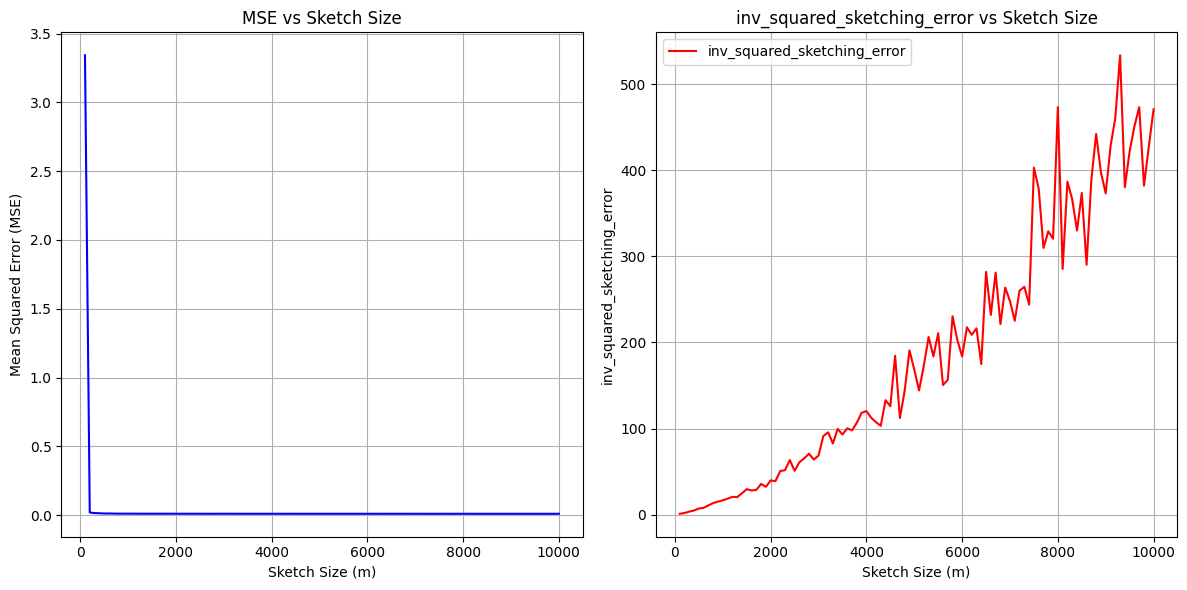

In [49]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["m"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sketch Size")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["m"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sketch Size (m)")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sketch Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

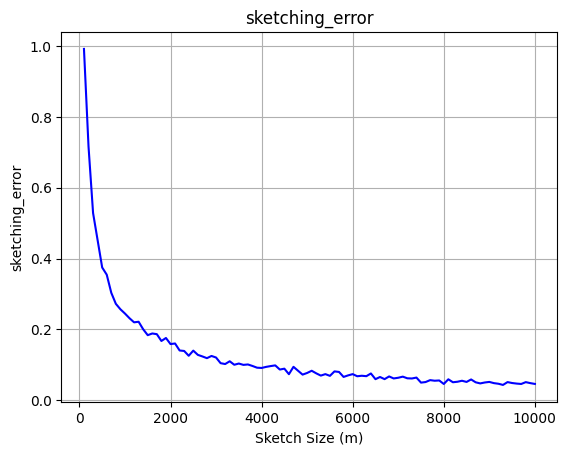

In [50]:
plt.plot(df_results["m"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

In [51]:
results = []
for m in m_values:
    # Compute estimated x
    S = fast_sketch_matrix(m,n)
    SX = S @ X_with_intercept
    SY = S @ y
    np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
    y_pred_sketched = X_with_intercept @ np_sketched_coefficients
    mse_sketched = mean_squared_error(y, y_pred_sketched)
    min_svd, max_svd = compute_min_max_svd(SX)
    # Store results for plotting
    results.append({"m": m, "MSE": mse_sketched, "Sparsity": non_zero_entries, "Min_SVD": min_svd,"Max_SVD": max_svd})

# Combine all results
df_results = pd.DataFrame(results)

In [52]:
df_results["min_svd_error"] = abs(1- (df_results["Min_SVD"]/min_svd_A))
df_results["max_svd_error"] = abs(1- (df_results["Max_SVD"]/max_svd_A))
df_results['sketching_error'] = df_results[["min_svd_error", "max_svd_error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)

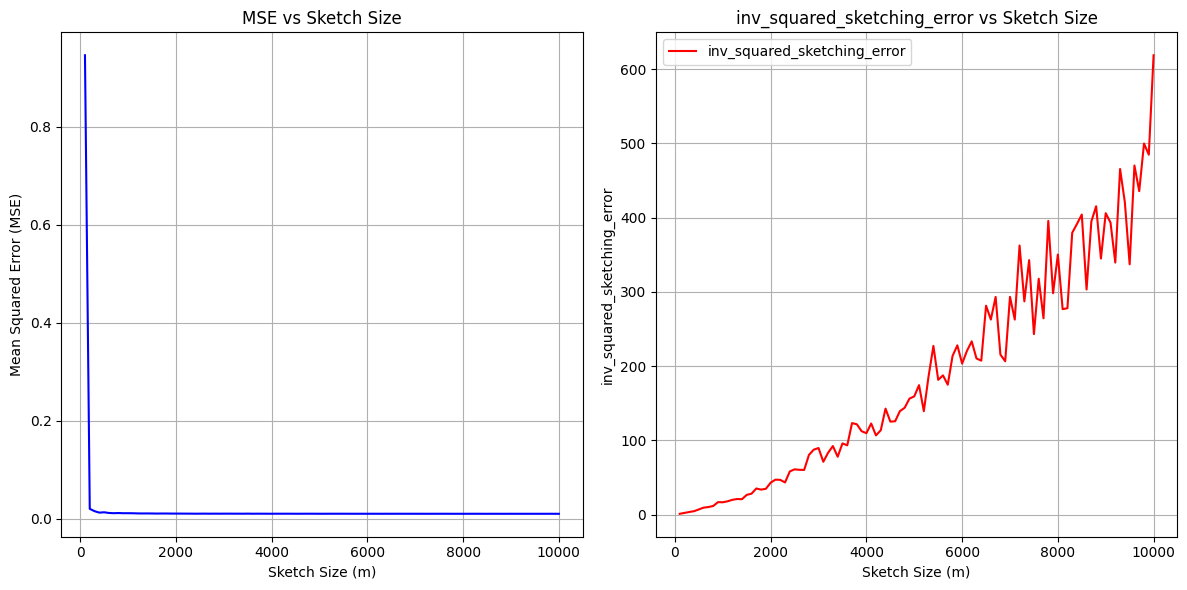

In [53]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["m"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sketch Size")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["m"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sketch Size (m)")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sketch Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

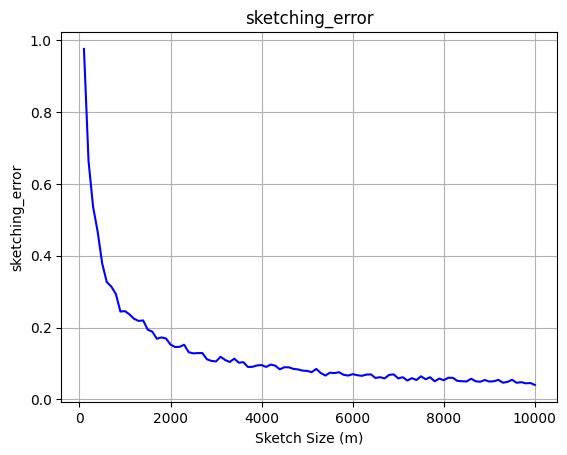

In [54]:
plt.plot(df_results["m"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

## s against mse and sketching

In [55]:
#varying s, elbow
m = 2000
non_zero_entries_list = list(range(2,m + 1 ,2))
# Store results
results = []

for non_zero_entries in non_zero_entries_list:
    # Compute estimated x
    S = sketch_matrix(m , n, non_zero_entries)
    SX = S @ X_with_intercept
    SY = S @ y
    np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
    y_pred_sketched = X_with_intercept @ np_sketched_coefficients
    mse_sketched = mean_squared_error(y, y_pred_sketched)
    min_svd, max_svd = compute_min_max_svd(SX)
    # Store results for plotting
    results.append({"m": m,"s" : non_zero_entries ,"MSE": mse_sketched, "Sparsity": non_zero_entries, "Min_SVD": min_svd,"Max_SVD": max_svd})

# Combine all results
df_results = pd.DataFrame(results)

### Convert to csv

In [115]:
df_results.to_csv('varying_s_data_application.csv', index=False)

In [56]:
df_results

,m,s,MSE,Sparsity,Min_SVD,Max_SVD
0,2000,2,0.010229,2,77.060612,125.570024
1,2000,4,0.010387,4,78.479767,124.095581
2,2000,6,0.010372,6,76.048077,124.498066
3,2000,8,0.010242,8,76.592428,123.615877
4,2000,10,0.010293,10,76.594577,125.565216
...,...,...,...,...,...,...
995,2000,1992,0.010162,1992,76.146650,123.479008
996,2000,1994,0.010322,1994,76.366292,124.583741
997,2000,1996,0.010206,1996,76.461654,125.288412
998,2000,1998,0.010212,1998,76.687406,124.458207


### Calculate min/max svd error and sketching_error/inverse sqaure sketching error

In [57]:
df_results["min_svd_error"] = abs(1- (df_results["Min_SVD"]/min_svd_A))
df_results["max_svd_error"] = abs(1- (df_results["Max_SVD"]/max_svd_A))
df_results['sketching_error'] = df_results[["min_svd_error", "max_svd_error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results

,m,s,MSE,Sparsity,Min_SVD,Max_SVD,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,2000,2,0.010229,2,77.060612,125.570024,0.151491,0.141249,0.151491,43.573813
1,2000,4,0.010387,4,78.479767,124.095581,0.135865,0.127848,0.135865,54.173300
2,2000,6,0.010372,6,76.048077,124.498066,0.162640,0.131506,0.162640,37.804613
3,2000,8,0.010242,8,76.592428,123.615877,0.156646,0.123489,0.156646,40.753026
4,2000,10,0.010293,10,76.594577,125.565216,0.156623,0.141205,0.156623,40.765338
...,...,...,...,...,...,...,...,...,...,...
995,2000,1992,0.010162,1992,76.146650,123.479008,0.161555,0.122245,0.161555,38.314291
996,2000,1994,0.010322,1994,76.366292,124.583741,0.159136,0.132285,0.159136,39.487696
997,2000,1996,0.010206,1996,76.461654,125.288412,0.158086,0.138689,0.158086,40.013999
998,2000,1998,0.010212,1998,76.687406,124.458207,0.155600,0.131144,0.155600,41.302672


### Visualiation

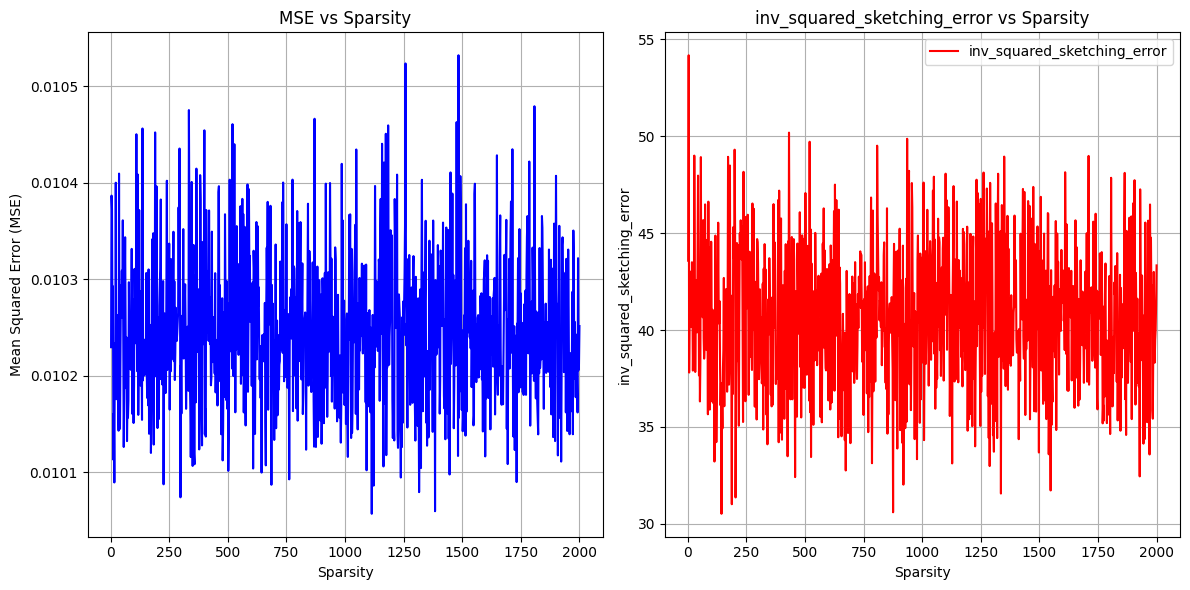

In [58]:
# Plot MSE vs s
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results["Sparsity"], df_results["MSE"], label="MSE", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sparsity")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_results["Sparsity"], df_results["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sparsity")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sparsity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

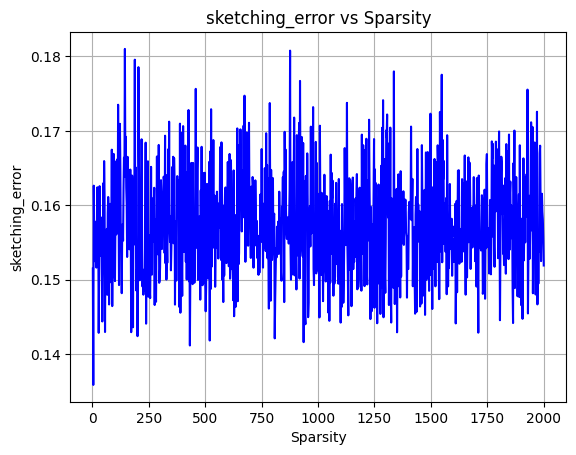

In [59]:
plt.plot(df_results["Sparsity"], df_results["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sparsity")
plt.ylabel("sketching_error")
plt.title("sketching_error vs Sparsity")
plt.grid(True)

# Housing dataset

## Data parsing and processing

In [14]:
df = pd.read_csv("../Dataset/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [15]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [16]:
X = df.drop(columns=['price'])
y = df['price']
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_cols)   # OneHotEncode categorical features
    ])

X_transformed = preprocessor.fit_transform(X)

### Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [29]:
# Add intercept (bias term) to X_train and X_test
X_train_lsq = np.c_[np.ones(X_train.shape[0]), X_train]  # Add column of ones
X_test_lsq = np.c_[np.ones(X_test.shape[0]), X_test]

In [30]:
X_train_lsq.shape

(327, 21)

### Initialising parameters

In [31]:
non_zero_entries = 10 #sparsity
n, d = X_train_lsq.shape 
m = 100 # lesser than n 

### OLS Sketched vs default

#### MSE for sketched

Default ols

In [32]:
np_coefficients, _, _, _ = np.linalg.lstsq(X_train_lsq, y_train, rcond=None)
y_pred_non_sketched = X_test_lsq @ np_coefficients
mse_non_sketched = mean_squared_error(y_test, y_pred_non_sketched)
mse_non_sketched

1506230725917.4587

In [ ]:
print("MSE / mean(y^2):", mse_non_sketched / np.mean(y**2))

MSE / mean(y^2): 0.05745938571710019


The error is small relative to the typical squared values of y

Fast sketch

In [ ]:
S = fast_sketch_matrix(m,n)
SX = S @ X_train_lsq
SY = S @ y_train
np_fast_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
y_pred_fast_sketched = X_test_lsq @ np_fast_sketched_coefficients
mse_fast_sketched = mean_squared_error(y_test, y_pred_fast_sketched)
mse_fast_sketched

1562852609895.644

In [36]:
print("MSE / mean(y^2):", mse_fast_sketched / np.mean(y**2))

MSE / mean(y^2): 0.059619385918629565


sketch wth sparsity of 10

In [38]:
S = sketch_matrix(m,n,non_zero_entries)
SX = S @ X_train_lsq
SY = S @ y_train
np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
y_pred_sketched = X_test_lsq @ np_sketched_coefficients
mse_sketched = mean_squared_error(y_test, y_pred_sketched)
mse_sketched

1571074925338.733

In [39]:
print("MSE / mean(y^2):", mse_sketched / np.mean(y**2))

MSE / mean(y^2): 0.05993304914857353


Comparing l2 norm using non sketched as benchmark

fast sketched

In [40]:
l2_norm = np.linalg.norm(np_coefficients - np_fast_sketched_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(np_coefficients)
print(f"Relative distance is {relative_distance}")

Distance is 636172.94128114
Relative distance is 0.22198170445193924


sketched with sparsity of 10

In [41]:
l2_norm = np.linalg.norm(np_coefficients - np_sketched_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(np_coefficients)
print(f"Relative distance is {relative_distance}")

Distance is 582304.8649008991
Relative distance is 0.20318535736689602


coefficient is stable and mse is good

In [128]:
x_estimated, min_svd, max_svd = fast_least_squares_sgd(X_train, y_train, non_zero_entries, m)
y_pred_sketch = X_test @ x_estimated
mse_sketch = np.mean((y_pred_sketch - y_test)**2)
mse_sketch

1512835415940.0642

#### MSE for default OLS

In [129]:
x_ols, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
y_pred_ols = X_test @ x_ols
mse_ols = np.mean((y_pred_ols - y_test)**2)
mse_ols

1506230725917.457

#### Analysis/comparison

In [130]:
relative_difference = abs(mse_sketch - mse_ols) / mse_ols
print(relative_difference)
mse_ratio = mse_sketch / mse_ols
print(mse_ratio)

0.0043849125561983265
1.0043849125561983


For relative difference : sketch approximation performs similarly to the OLS model with respect to error.
mse_ratio > 1, the sketch has a higher error compared to OLS.

# Student performance dataset

## Data parsing and processing

In [42]:
df = pd.read_csv("../Dataset/Student_Performance.csv")
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [43]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [44]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [45]:
df.shape

(10000, 6)

In [46]:
X = df.drop(columns='Performance Index')
y = df['Performance Index']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train.shape

(8000, 5)

In [49]:
# Add intercept (bias term) to X_train and X_test
X_train_lsq = np.c_[np.ones(X_train.shape[0]), X_train]  # Add column of ones
X_test_lsq = np.c_[np.ones(X_test.shape[0]), X_test]

### Intialising parameters

In [50]:
non_zero_entries = 10 #sparsity (<m)
n, d = X_train_lsq.shape 
m = 2000 # lesser than n 

### MSE of regular OLS

In [51]:
np_coefficients, _, _, _ = np.linalg.lstsq(X_train_lsq, y_train, rcond=None)
y_pred_non_sketched = X_test_lsq @ np_coefficients
mse_non_sketched = mean_squared_error(y_test, y_pred_non_sketched)
mse_non_sketched

4.082628398521851

In [52]:
print("MSE / mean(y^2):", mse_non_sketched / np.mean(y**2))

MSE / mean(y^2): 0.0011941476462713494


### sketch and fast sketch

fast sketch

In [54]:
S = fast_sketch_matrix(m,n)
SX = S @ X_train_lsq
SY = S @ y_train
np_fast_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
y_pred_fast_sketched = X_test_lsq @ np_fast_sketched_coefficients
mse_fast_sketched = mean_squared_error(y_test, y_pred_fast_sketched)
mse_fast_sketched

4.111607541700614

In [55]:
print("MSE / mean(y^2):", mse_fast_sketched / np.mean(y**2))

MSE / mean(y^2): 0.0012026238954520024


sketch

In [56]:
S = sketch_matrix(m,n,non_zero_entries)
SX = S @ X_train_lsq
SY = S @ y_train
np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
y_pred_sketched = X_test_lsq @ np_sketched_coefficients
mse_sketched = mean_squared_error(y_test, y_pred_sketched)
mse_sketched

4.111568874211199

In [57]:
print("MSE / mean(y^2):", mse_sketched / np.mean(y**2))

MSE / mean(y^2): 0.001202612585411762


l2-norm against the default for comparison

fast sketch

In [58]:
l2_norm = np.linalg.norm(np_coefficients - np_fast_sketched_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(np_coefficients)
print(f"Relative distance is {relative_distance}")

Distance is 0.1224813159434682
Relative distance is 0.0020949384021740716


sketch with sparsity 10

In [60]:
l2_norm = np.linalg.norm(np_coefficients - np_sketched_coefficients)
print(f"Distance is {l2_norm}")

relative_distance = l2_norm/np.linalg.norm(np_coefficients)
print(f"Relative distance is {relative_distance}")

Distance is 0.1346196379955222
Relative distance is 0.002302554043865423


In [159]:
x_ols, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
y_pred_ols = X_test @ x_ols
mse_ols = np.mean((y_pred_ols - y_test)**2)
mse_ols

3052.59869597723

50 iterations

In [62]:
# Initialize timing lists
results = []

for i in range(50):
    # 🚀 **Non-sketch (Baseline)**
    start = time.time()
    np_coefficients, _, _, _ = np.linalg.lstsq(X_train_lsq, y_train, rcond=None)
    non_sketch_time = time.time() - start

    # 🚀 **Fast Sketch**
    start_total = time.time()
    
    start_gen = time.time()
    S_fast = fast_sketch_matrix(m, n)
    fast_sketch_gen_time = time.time() - start_gen
    
    start_mult = time.time()
    SX_fast = S_fast @ X_train_lsq
    SY_fast = S_fast @ y_train
    fast_sketch_mult_time = time.time() - start_mult
    
    start_lstsq = time.time()
    np_fast_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX_fast, SY_fast, rcond=None)
    fast_sketch_lstsq_time = time.time() - start_lstsq
    
    fast_sketch_total_time = time.time() - start_total

    # 🚀 **Regular Sketch**
    start_total = time.time()
    
    start_gen = time.time()
    S = sketch_matrix(m, n, non_zero_entries)
    sketch_gen_time = time.time() - start_gen
    
    start_mult = time.time()
    SX = S @ X_train_lsq
    SY = S @ y_train
    sketch_mult_time = time.time() - start_mult
    
    start_lstsq = time.time()
    np_sketched_coefficients, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
    sketch_lstsq_time = time.time() - start_lstsq
    
    sketch_total_time = time.time() - start_total

    # Append results to list
    results.append([
        non_sketch_time, 
        fast_sketch_total_time, fast_sketch_gen_time, fast_sketch_mult_time, fast_sketch_lstsq_time,
        sketch_total_time, sketch_gen_time, sketch_mult_time, sketch_lstsq_time
    ])

# Convert to DataFrame
columns = [
    "Non-Sketch Time",
    "Fast Sketch Total Time", "Fast Sketch Gen Time", "Fast Sketch Mult Time", "Fast Sketch Lstsq Time",
    "Regular Sketch Total Time", "Regular Sketch Gen Time", "Regular Sketch Mult Time", "Regular Sketch Lstsq Time"
]
df_results = pd.DataFrame(results, columns=columns)

# Compute averages
df_avg = df_results.mean().to_frame(name="Average Time (sec)")

In [63]:
df_avg

,Average Time (sec)
Non-Sketch Time,0.000316
Fast Sketch Total Time,0.000732
Fast Sketch Gen Time,0.000289
Fast Sketch Mult Time,0.000190
Fast Sketch Lstsq Time,0.000253
Regular Sketch Total Time,0.555458
Regular Sketch Gen Time,0.536478
Regular Sketch Mult Time,0.018714
Regular Sketch Lstsq Time,0.000265


### MSE of ridge regression

In [157]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
x_ridge = ridge_model.coef_ #coefficient
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

4.083211367310288

Difference might be due to intercept

### MSE of regular OLS accounting for y-intercept

In [163]:
X_train_with_intercept = np.column_stack([np.ones(X_train.shape[0]), X_train])
X_test_with_intercept = np.column_stack([np.ones(X_test.shape[0]), X_test])
x_ols, _, _, _ = np.linalg.lstsq(X_train_with_intercept, y_train, rcond=None)
y_pred_ols = X_test_with_intercept @ x_ols
mse_ols = np.mean((y_pred_ols - y_test)**2)
mse_ols

4.082628398521851

### Sketched OLS with intercept

In [168]:
x_sketched, intercept ,min_svd_error, max_svd_error = fast_least_squares_sgd_with_intercept(X_train, y_train, non_zero_entries, m)
y_pred_sketch = X_test @ x_sketched + intercept
mse_sgd_sketch = mean_squared_error(y_test, y_pred_sketch)
mse_sgd_sketch

4.103913260705038

### Sketched OLS regularised with intercept

In [185]:
x_sketched_regularised, intercept, _ ,min_svd_error, max_svd_error = fast_least_squares_sgd_regularized_with_intercept(X_train, y_train, non_zero_entries, m,lambda_reg=1e-3)
y_pred_sketch = X_test @ x_sketched_regularised + intercept
mse_sgd_sketch_regularised = mean_squared_error(y_test, y_pred_sketch)
mse_sgd_sketch_regularised

4.089354033000808

# Further analysis

## Sketched non regularisation

In [189]:
non_zero_entries = 10 #sparsity (<m)
n, d = X_train.shape 
m = 2000 # lesser than n 
iterations = 10
min_svds = []
max_svds = []
x_sgd_results = []
mse_list = []
intercept_list = []

# Iterate over the number of iterations
for i in range(iterations):
    x_sgd, intercept, min_svd, max_svd = fast_least_squares_sgd_with_intercept(X_train, y_train, non_zero_entries, m)
    x_sgd_results.append(x_sgd)
    min_svds.append(min_svd)
    max_svds.append(max_svd)
    intercept_list.append(intercept)
    y_pred_sgd = X_test @ x_sgd + intercept
    mse_sgd_reg = mean_squared_error(y_test, y_pred_sgd)
    mse_list.append(mse_sgd_reg)


x_sgd_sketch_results_df = pd.DataFrame(x_sgd_results)
x_sgd_sketch_results_df["intercept"] = intercept_list
x_sgd_sketch_results_df["Min_SVD"] = min_svds
x_sgd_sketch_results_df["Max_SVD"] = max_svds
x_sgd_sketch_results_df["mse"] = mse_list

In [190]:
x_sgd_sketch_results_df

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343
5,7.326196,17.636917,0.281281,0.841707,0.583430,55.140216,85.577476,93.513911,4.080667
6,7.413774,17.553768,0.317450,0.839714,0.627275,55.265694,85.643134,92.373176,4.115988
7,7.399924,17.665336,0.240942,0.874828,0.555778,55.213840,84.640479,93.225581,4.078413
8,7.340988,17.644951,0.303556,0.810459,0.506969,55.239749,86.869305,93.154647,4.087438
9,7.499027,17.625939,0.273125,0.812884,0.506624,55.246272,85.830607,92.347580,4.103677


## Sketched regularisation

In [193]:
intercept_list = []
min_svds = []
max_svds = []
x_sgd_reg_results = []
mse_list = []

# Iterate over the number of iterations
for i in range(iterations):
    x_sgd_reg, reg_intercept, _, min_svd, max_svd = fast_least_squares_sgd_regularized_with_intercept(X_train, y_train, non_zero_entries,m, lambda_reg=1e-3)
    x_sgd_reg_results.append(x_sgd_reg)
    intercept_list.append(reg_intercept)
    min_svds.append(min_svd)
    max_svds.append(max_svd)
    y_pred_sgd_reg = X_test @ x_sgd_reg + reg_intercept
    mse_sgd_reg = mean_squared_error(y_test, y_pred_sgd_reg)
    mse_list.append(mse_sgd_reg)


x_sgd_results_reg_df = pd.DataFrame(x_sgd_reg_results)
x_sgd_results_reg_df["intercept"] = intercept_list
x_sgd_results_reg_df["Min_SVD"] = min_svds
x_sgd_results_reg_df["Max_SVD"] = max_svds
x_sgd_results_reg_df["mse"] = mse_list

In [ ]:
x_sgd_results_reg_df

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038
5,7.324919,17.657071,0.307228,0.790117,0.577996,55.252545,85.651464,94.186057,4.084665
6,7.393180,17.569311,0.331994,0.813311,0.465992,55.261643,84.169013,92.861517,4.119649
7,7.406991,17.587046,0.232537,0.816973,0.587530,55.212058,87.271688,94.017591,4.099665
8,7.360547,17.624271,0.335073,0.806664,0.533025,55.234786,84.073440,92.885563,4.087523
9,7.354081,17.638121,0.257065,0.793418,0.547408,55.227485,83.258195,93.611477,4.086335


## Put the coeefficient and intercept into an array

### Sketched non reg

In [200]:
x_sgd_sketch_results_df["x_array"] = x_sgd_sketch_results_df.iloc[:, 0:6].apply(lambda row: row.values, axis=1)
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091,"[7.463638335810351, 17.625802624227365, 0.2248..."
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019,"[7.41573359230728, 17.664147966347528, 0.28691..."
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479,"[7.398503570854378, 17.626566643451415, 0.2811..."
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110,"[7.387844073722896, 17.66211961569598, 0.31476..."
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343,"[7.370297808466278, 17.655840697216995, 0.2906..."


### Sketched reg

In [ ]:
x_sgd_results_reg_df["x_array"] = x_sgd_results_reg_df.iloc[:, 0:6].apply(lambda row: row.values, axis=1)
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188,"[7.323648490313978, 17.6591899750168, 0.343482..."
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066,"[7.340991879591277, 17.613063220199084, 0.2142..."
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786,"[7.3676779013826295, 17.632038694086436, 0.300..."
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244,"[7.337394141179786, 17.693364878125802, 0.3235..."
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038,"[7.394111177416938, 17.614093863930886, 0.2606..."


## Comparing distance of coefficient

### Default OLS vs sketched OLS

#### Reorder intercept to last index 

In [206]:
ols_coef = np.append(x_ols[1:],x_ols[0])
ols_coef

array([ 7.38559242, 17.63689926,  0.30429188,  0.80878696,  0.55001995,
       55.2407568 ])

In [ ]:
distances = []
for index, row in x_sgd_sketch_results_df.iterrows():
    # Extract x_sgd_array from each row
    x_sgd_array = row['x_array']
    # Calculate the distance from regression_coeff
    distance = np.linalg.norm(x_sgd_array - ols_coef)
    # Append the calculated distance
    distances.append(distance)

# Assign the calculated distances to the new 'distance' column
x_sgd_sketch_results_df['distance'] = distances
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091,"[7.463638335810351, 17.625802624227365, 0.2248...",0.130072
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019,"[7.41573359230728, 17.664147966347528, 0.28691...",0.084751
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479,"[7.398503570854378, 17.626566643451415, 0.2811...",0.092329
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110,"[7.387844073722896, 17.66211961569598, 0.31476...",0.042082
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343,"[7.370297808466278, 17.655840697216995, 0.2906...",0.054451


### Ridge vs sketch regularisation

#### merge coefficient with intercept for ridge

In [212]:
ridge_coef = np.append(x_ridge,ridge_model.intercept_)
ridge_coef

array([ 7.38465051, 17.63468517,  0.30426091,  0.80869184,  0.54998809,
       55.24076516])

In [213]:
distances = []
for index, row in x_sgd_results_reg_df.iterrows():
    # Extract x_sgd_array from each row
    x_sgd_array = row['x_array']
    # Calculate the distance from regression_coeff
    distance = np.linalg.norm(x_sgd_array - ridge_coef)
    # Append the calculated distance
    distances.append(distance)

# Assign the calculated distances to the new 'distance' column
x_sgd_results_reg_df['distance'] = distances
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188,"[7.323648490313978, 17.6591899750168, 0.343482...",0.090485
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066,"[7.340991879591277, 17.613063220199084, 0.2142...",0.112713
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786,"[7.3676779013826295, 17.632038694086436, 0.300...",0.070355
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244,"[7.337394141179786, 17.693364878125802, 0.3235...",0.095371
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038,"[7.394111177416938, 17.614093863930886, 0.2606...",0.056199


## Sketching error

### SVD of original train data

In [215]:
min_svd_X_train, max_svd_X_train = compute_min_max_svd(X_train)
print(f"min svd of A is {min_svd_X_train}")
print(f"max svd of A is {max_svd_X_train}")

min svd of A is 88.20594154424597
max svd of A is 90.49370701837194


### Sketching error and inverse sketching error squared of non regularisation sketch

In [ ]:
x_sgd_sketch_results_df["min_svd_error"] = abs(1- (x_sgd_sketch_results_df["Min_SVD"]/min_svd_X_train))
x_sgd_sketch_results_df["max_svd_error"] = abs(1- (x_sgd_sketch_results_df["Max_SVD"]/max_svd_X_train))
x_sgd_sketch_results_df['sketching_error'] = x_sgd_sketch_results_df[["min_svd_error", "max_svd_error"]].max(axis=1)
x_sgd_sketch_results_df["inv_squared_sketching_error"] = 1 / (x_sgd_sketch_results_df["sketching_error"] ** 2)
x_sgd_sketch_results_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,7.463638,17.625803,0.224892,0.829878,0.504846,55.284512,84.830372,93.365231,4.112091,"[7.463638335810351, 17.625802624227365, 0.2248...",0.130072,0.038269,0.031732,0.038269,682.812814
1,7.415734,17.664148,0.286918,0.836082,0.610813,55.268846,84.576572,92.266421,4.082019,"[7.41573359230728, 17.664147966347528, 0.28691...",0.084751,0.041147,0.019589,0.041147,590.654089
2,7.398504,17.626567,0.281120,0.752296,0.610487,55.270195,85.643580,93.601576,4.098479,"[7.398503570854378, 17.626566643451415, 0.2811...",0.092329,0.029050,0.034343,0.034343,847.835166
3,7.387844,17.662120,0.314769,0.835129,0.547892,55.258689,87.448693,92.804421,4.079110,"[7.387844073722896, 17.66211961569598, 0.31476...",0.042082,0.008585,0.025535,0.025535,1533.714629
4,7.370298,17.655841,0.290605,0.789178,0.583909,55.266289,84.833401,93.465031,4.084343,"[7.370297808466278, 17.655840697216995, 0.2906...",0.054451,0.038235,0.032835,0.038235,684.039746


### Sketching error and inverse sketching error squared of regularisation sketch

In [218]:
x_sgd_results_reg_df["min_svd_error"] = abs(1- (x_sgd_results_reg_df["Min_SVD"]/min_svd_X_train))
x_sgd_results_reg_df["max_svd_error"] = abs(1- (x_sgd_results_reg_df["Max_SVD"]/max_svd_X_train))
x_sgd_results_reg_df['sketching_error'] = x_sgd_results_reg_df[["min_svd_error", "max_svd_error"]].max(axis=1)
x_sgd_results_reg_df["inv_squared_sketching_error"] = 1 / (x_sgd_results_reg_df["sketching_error"] ** 2)
x_sgd_results_reg_df.head()

,0,1,2,3,4,intercept,Min_SVD,Max_SVD,mse,x_array,distance,min_svd_error,max_svd_error,sketching_error,inv_squared_sketching_error
0,7.323648,17.659190,0.343482,0.841497,0.576020,55.264716,85.975402,91.880505,4.085188,"[7.323648490313978, 17.6591899750168, 0.343482...",0.090485,0.025288,0.015325,0.025288,1563.780618
1,7.340992,17.613063,0.214222,0.812172,0.543324,55.194214,85.096803,93.859579,4.097066,"[7.340991879591277, 17.613063220199084, 0.2142...",0.112713,0.035249,0.037195,0.037195,722.838851
2,7.367678,17.632039,0.300644,0.850275,0.497600,55.253727,84.592267,93.543594,4.091786,"[7.3676779013826295, 17.632038694086436, 0.300...",0.070355,0.040969,0.033703,0.040969,595.796061
3,7.337394,17.693365,0.323532,0.816604,0.604452,55.236433,85.020351,92.471546,4.073244,"[7.337394141179786, 17.693364878125802, 0.3235...",0.095371,0.036115,0.021856,0.036115,766.683127
4,7.394111,17.614094,0.260633,0.797608,0.553030,55.265449,85.694924,93.145059,4.097038,"[7.394111177416938, 17.614093863930886, 0.2606...",0.056199,0.028468,0.029299,0.029299,1164.935530


#### Average performance

##### non regularisation sketch

In [220]:
temp = x_sgd_sketch_results_df.drop(columns = "x_array")
sketch_average = temp.mean()
sketch_average

0                                7.401593
1                               17.636139
2                                0.281466
3                                0.822215
4                                0.563802
intercept                       55.245430
Min_SVD                         85.589362
Max_SVD                         93.011757
mse                              4.092222
distance                         0.094514
min_svd_error                    0.029664
max_svd_error                    0.027826
sketching_error                  0.033671
inv_squared_sketching_error    956.891803
dtype: float64

##### regularisation sketch

In [221]:
temp = x_sgd_results_reg_df.drop(columns = "x_array")
sketch_average = temp.mean()
sketch_average

0                                7.360354
1                               17.628757
2                                0.290641
3                                0.813864
4                                0.548638
intercept                       55.240306
Min_SVD                         85.080355
Max_SVD                         93.246249
mse                              4.092216
distance                         0.081595
min_svd_error                    0.035435
max_svd_error                    0.030417
sketching_error                  0.039732
inv_squared_sketching_error    732.498225
dtype: float64

# Comparing computational cost in term of time

## Intiatise well conditioned data matrix with bigger dimension 

In [30]:
#Feature matrix
n = 1000000
d = 500
X = np.random.randn(n, d)

#True coefficients
true_x_coefficient = np.random.randn(d)

#target vector
y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

### nplstq: sketched vs non sketched vs fast sketch

#### Non sketched

In [31]:
iterations = 10
results = []

for i in range(iterations):
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(X, y, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    
    results.append({'iteration': i, 'time': iteration_time, 'x_estimate' : x_estimate})
non_sketch_nplstq_df = pd.DataFrame(results)

In [32]:
non_sketch_nplstq_df

,iteration,time,x_estimate
0,0,40.963815,"[1.972260926578052, 0.5489597994416611, 0.6092..."
1,1,39.198472,"[1.972260926578052, 0.5489597994416611, 0.6092..."
2,2,38.862706,"[1.972260926578052, 0.5489597994416611, 0.6092..."
3,3,34.785224,"[1.972260926578052, 0.5489597994416611, 0.6092..."
4,4,33.585307,"[1.972260926578052, 0.5489597994416611, 0.6092..."
5,5,34.773538,"[1.972260926578052, 0.5489597994416611, 0.6092..."
6,6,33.997202,"[1.972260926578052, 0.5489597994416611, 0.6092..."
7,7,37.342870,"[1.972260926578052, 0.5489597994416611, 0.6092..."
8,8,34.333338,"[1.972260926578052, 0.5489597994416611, 0.6092..."
9,9,33.620739,"[1.972260926578052, 0.5489597994416611, 0.6092..."


In [37]:
avg_non_sketch_nplstq_df = non_sketch_nplstq_df.mean()
avg_non_sketch_nplstq_df

TypeError: Could not convert [array([ 1.97226093e+01,  5.48959799e+00,  6.09237597e+00,  1.83332130e+01,
        -2.25455401e+01,  9.18610452e-01, -1.29286530e+01, -8.36046645e+00,
        -1.18580701e+01,  5.77931583e+00,  1.69664866e+01, -2.22364825e+01,
         1.86666526e+01, -5.00634903e+00, -6.31197389e+00,  6.81104151e+00,
         5.39577341e+00, -6.59501530e+00, -1.67280404e+01,  6.42173698e+00,
         1.03435634e+01, -1.27501512e+01,  1.19507646e+01, -4.99199072e+00,
        -4.99789300e+00, -2.02581837e+01, -6.29619224e+00,  1.64622420e+01,
        -2.51841231e+00,  3.03870534e+00, -5.87905043e+00, -3.79836060e+00,
         5.01590481e+00,  1.91679746e+00,  9.15632066e-01, -7.75579902e+00,
        -2.60741287e+01, -3.70915595e+00, -1.10936152e+01, -1.94239906e+00,
        -1.14839833e+01,  8.36563520e+00, -3.03940726e+00, -1.54866370e+01,
         1.04411693e+01,  2.91250229e-01,  8.39465987e+00,  5.56288843e+00,
         6.83271329e+00, -2.62057260e+00, -1.07703153e+01, -2.75900402e+00,
        -6.26555696e-01,  1.49077239e+01, -1.44542367e+01,  9.99265930e+00,
        -1.23921736e+01,  1.83391124e+00, -2.10493114e+00, -1.39742062e+01,
         8.27885251e+00,  5.00181982e+00,  9.72262910e+00, -3.85167629e+00,
        -3.72074424e+00,  9.47842943e+00, -1.02653718e+01, -1.38696982e+01,
        -1.05220403e+01,  5.80806451e+00, -1.51077551e+01, -4.88825951e+00,
         2.38224967e+01,  1.49585134e+01,  9.45561536e-01, -6.31217185e+00,
         6.82233634e+00, -1.41242418e+01,  5.07793442e+00, -1.77461607e+01,
        -3.21094680e+00, -2.33241773e+01, -4.73444161e+00,  3.31278443e-01,
         4.89944876e+00, -1.01131269e+01, -2.14646391e+01, -4.83754713e+00,
        -3.68273479e+00,  3.41358816e+00,  3.43989523e+00, -8.03953977e+00,
         5.55216911e-01,  1.43017738e+00, -1.04729740e+00, -1.35012207e+01,
        -1.87918831e+01,  4.32618868e+00,  1.00523012e+01, -2.31061702e+00,
        -7.37944058e+00,  3.87148325e+00, -6.50763304e+00, -1.22973914e+01,
        -2.93461489e+00,  4.36440985e+00, -6.85927159e+00,  4.47940376e+00,
        -1.71303885e+00,  1.10115315e+00, -3.83790762e+00,  7.68236020e+00,
        -4.90622833e+00,  1.52889076e+00, -5.77765660e+00,  8.15067977e-01,
        -1.07156301e+00,  9.40164250e+00, -6.90224087e+00,  1.23937794e+01,
        -1.01989380e+01,  1.88060980e+01, -6.11105226e+00,  3.82848307e+00,
         2.63995951e+00, -1.33922637e+00, -2.12398725e+00, -2.39022456e+01,
        -8.39533542e+00, -1.61499343e+01,  2.02121521e+01, -2.88804276e+00,
         7.30520350e+00, -8.75950313e+00,  3.36134066e+00, -1.61448494e+00,
         4.97665242e+00, -5.97497682e+00,  1.08429138e+01, -1.78827454e+01,
        -2.83329486e+00,  4.40764892e+00,  2.38161476e+00, -1.76124555e+01,
         1.51680593e+01,  3.85390251e+00, -7.46770791e+00, -2.61160966e+00,
        -7.30864607e+00,  1.13106398e+01,  1.43751223e+01, -5.14187026e+00,
        -1.01433368e+01, -9.03783878e+00, -2.46220064e+00,  1.24214212e+01,
         8.38850691e+00,  6.37707091e-01, -3.06467680e-01,  4.63406860e+00,
        -1.67581421e+01, -1.61112694e+01, -5.53034474e-01, -2.73902225e+01,
        -5.30150541e+00, -9.55869718e+00, -8.44780103e-01, -1.96509294e+01,
        -2.50791288e+01, -7.68400975e+00, -1.66343947e+01,  1.19624937e+01,
        -9.60815610e+00,  1.40852683e+01, -1.76476326e-01, -1.77660965e+01,
         7.88685423e+00, -3.53272692e+00,  4.11078428e+00, -9.30243215e+00,
        -8.22049863e+00, -1.67597119e+00,  5.96167252e+00, -7.20636854e+00,
         2.87130736e+00,  5.46369500e+00, -2.84733839e+00,  2.06712211e+01,
         5.43050919e+00, -9.23227418e+00,  2.91320467e+00, -1.16704711e+00,
         4.86335447e+00,  6.15728409e+00, -8.73628213e-03, -1.60687366e+01,
        -1.10018234e+01, -3.57472146e+00, -5.11863521e+00, -8.26287726e+00,
        -9.70294546e+00,  1.58167838e+01, -1.83315536e+01,  3.85008617e+00,
        -5.99867256e-01,  8.97053750e+00, -3.25009757e+00,  2.73258738e+00,
         9.15276652e-01, -8.71931479e+00,  1.55259315e+00, -2.28152730e+00,
        -1.01571226e+01,  7.29935540e+00,  4.50125065e+00,  5.90671592e+00,
        -4.06261031e-01,  3.20666750e+00,  1.76844490e+01,  3.78320915e+00,
         1.44610205e+01, -1.85974373e+00, -1.49494790e+01, -1.48128223e+01,
         4.85016149e+00, -4.13719950e+00,  5.95614104e+00, -6.18884892e+00,
         2.91050144e+00,  9.53852352e+00, -4.69889640e+00, -2.32649533e+01,
         2.25014181e+01,  3.39971996e+00, -5.06943232e+00,  1.48027280e+01,
        -1.44221018e+01, -7.84918826e+00, -9.80065739e+00, -9.18997987e+00,
         1.95287079e+01,  5.51960788e+00, -8.48802883e+00,  1.57042646e+00,
         5.55834151e+00,  4.19062051e+00, -7.48190685e+00,  4.55217740e+00,
         3.42636904e+00,  8.20347481e+00, -1.47765505e+00,  1.12978902e+01,
        -9.05946263e+00, -8.14027595e+00,  1.14694029e+01,  4.52703689e-01,
         1.23638247e+00, -2.59257679e+00,  1.30351087e+01,  3.09666598e+00,
         8.23402636e+00,  3.24227541e+00,  1.59651701e+01,  9.51285717e+00,
        -9.14665332e+00,  3.27309019e+00,  6.06171370e+00, -4.58642566e+00,
         1.53026446e+01,  8.90073342e+00, -1.84795542e+01, -1.99603015e+01,
        -3.34287500e+00, -1.58007857e+01,  3.55544100e+00, -1.25943470e+01,
         1.78438398e+01, -1.25835842e+01, -7.98124992e+00, -1.39864304e+01,
         1.15997438e+01,  2.08974415e+00,  3.62795895e+00, -8.91635280e+00,
        -1.38756335e+01, -7.69119927e+00,  2.14249906e+00,  9.24397369e+00,
        -1.83139686e+01,  5.33535505e+00, -2.05065023e+00,  1.05936202e+01,
         1.35125343e+01,  1.37024572e+01,  1.14727714e+01,  2.35505430e+00,
         1.50495655e-01, -2.94931220e+00,  6.24725130e-03,  1.03525381e+00,
        -8.65881900e+00, -1.94692969e+00, -7.77741733e+00,  2.57257500e-01,
         7.07974066e+00,  9.70035391e+00, -9.67879304e+00,  5.76407608e+00,
         5.53454792e+00,  9.20522845e+00, -5.37019013e+00, -5.67685081e-01,
        -1.37213952e+01, -3.31205781e+00,  1.10931871e+01,  4.87352076e+00,
        -5.59002745e+00, -6.34829952e+00, -5.90861047e+00, -1.41765745e+01,
         9.14415301e+00,  5.26140696e+00, -6.89785774e+00, -1.76169230e+01,
         1.75558149e+00,  1.66505423e+01,  2.61891397e+00, -9.32742830e+00,
         1.60692432e+01,  5.00751952e+00,  2.13011488e+01,  1.17758570e+01,
         6.30188410e+00,  1.25942425e+01,  5.77827661e-01,  2.25513867e+01,
        -8.92921087e+00,  4.50915309e-01, -1.96739748e+00, -8.87846762e+00,
        -1.34471783e+01, -2.59400643e+00,  1.02952997e+00, -1.58454552e+00,
         7.25545825e+00,  1.15155917e+01,  5.08416285e+00, -2.58176976e+00,
        -1.12299841e+01, -3.61317519e+00, -4.08484324e+00, -3.18467342e+00,
        -1.08600159e+00,  2.04541204e+01,  4.77801430e+00, -1.17486881e+01,
         8.62537449e+00,  6.43857744e+00,  1.16803143e+01, -6.87826949e+00,
         3.86267829e+00,  2.21717706e+00,  6.23378014e+00,  1.08605640e+01,
        -2.20703960e+00, -9.88427402e+00, -1.85634862e+00,  1.19087873e+01,
         1.28158146e+01, -1.14308095e+01, -5.17124368e+00,  4.89287308e-01,
        -1.21153178e+01, -6.60771802e+00, -8.62440602e+00,  5.56782736e+00,
        -7.13768648e+00, -2.36744940e+01,  6.01656903e+00,  1.74082295e+01,
        -2.41842140e+01, -5.09156583e+00,  1.01855479e+01, -2.86217547e+01,
        -1.18454514e+01,  1.37419536e+00, -1.52117071e+00, -3.71568726e+00,
        -1.09020454e+01, -1.28272053e+01, -5.13162992e-01, -1.32864166e+01,
         4.20973945e+00,  1.98348512e+01,  8.51012629e+00, -3.68362363e+00,
         9.30801564e+00, -1.49265176e+00, -1.11062675e+01, -1.14663089e+01,
        -3.93307191e+00,  6.51870034e+00,  7.26595880e+00,  8.93043117e+00,
         3.08843066e+00, -4.89148039e+00, -2.22262650e+00,  6.52509822e+00,
         2.78401453e-01,  1.56528892e+01, -5.22232084e+00,  4.04426055e-01,
        -8.40384584e+00, -2.82632893e+00,  1.18535941e+00,  4.15085578e+00,
        -2.77292047e+00, -2.98866979e+00, -3.22507719e+00, -1.62917193e+01,
        -5.63060444e+00,  1.34072652e+01, -1.22327129e+01, -1.09114719e+00,
         8.22938333e+00, -7.28718225e+00,  1.13059557e+01,  8.96678202e+00,
         6.77306651e+00,  1.12409130e+01,  3.88138827e+00, -1.71337099e+00,
         3.58666503e+00, -3.68591222e+00, -3.44191137e+00, -2.72120415e-01,
        -8.04292714e+00,  1.86711056e+00,  4.33785755e+00,  1.21739978e+01,
        -1.31945290e+01,  5.68377176e+00, -1.64388609e+01, -1.83202937e+01,
        -2.90666873e+00,  5.28845437e-01,  1.02957747e+01, -5.61662408e+00,
         5.92917139e+00,  1.33375388e+01, -4.46521570e+00,  3.85206996e+00,
        -1.76586462e+01, -1.66006684e+01,  7.52081058e+00, -1.23338910e+01,
        -2.09373524e+01, -3.09433052e-01,  6.15140259e+00,  7.94226943e+00,
        -1.41582332e+01, -5.87264782e+00, -1.60973904e+00, -6.98717760e+00,
         1.69998437e+00,  1.07588736e+01,  1.98371167e+00, -5.22699805e+00,
         2.04894273e+00,  1.01810885e+01,  8.28466814e+00, -7.45695264e+00,
         9.01965792e+00, -6.91289286e+00,  1.11241955e+01,  1.18918814e+01,
        -1.28282940e+01, -1.18522009e+01, -1.33596376e+01, -6.80086408e+00,
        -4.51149940e+00, -1.60400491e+01,  1.19186329e+01,  1.07578764e+01,
         8.41549341e+00,  3.78055741e+00,  7.76733901e+00, -9.29066719e+00,
         1.47921462e+01, -6.21483460e-01,  1.57029883e+01, -4.57919016e-02,
        -7.11178031e+00,  3.61132763e+00, -6.79302327e+00,  1.17011537e+01,
         7.24597448e+00,  5.18837291e+00, -1.32371509e+00,  1.06920576e+01])] to numeric

Same estiamte values because X and y stays the same

#### Sketched

In [33]:
iterations = 10
results = []
m = 250
non_zero_entries = 1

for i in range(iterations):
    start_time = time.time()
    S = sketch_matrix(m, n, non_zero_entries)
    SX = S @ X
    SY = S @ y
    
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'iteration': i, 'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate})

sketched_nplstq_df = pd.DataFrame(results)

In [34]:
sketched_nplstq_df

,iteration,total time,iteration time,sketch time,x_estimate
0,0,31.691980,0.079172,31.612808,"[0.7098904473472785, -0.22234095497598427, 0.6..."
1,1,31.121694,0.082347,31.039347,"[0.4942460968483501, 0.15674172040733986, 0.55..."
2,2,31.928637,0.075042,31.853595,"[1.3346926006004085, 0.0671132249565126, 0.598..."
3,3,31.149305,0.088403,31.060901,"[0.5700779558142295, 0.5252449694642418, 0.285..."
4,4,31.299984,0.087873,31.212111,"[1.3810035433426444, -0.2765489987549477, 0.14..."
5,5,30.670167,0.091686,30.578481,"[1.5967383666435064, 0.5342927972721367, 1.066..."
6,6,32.913807,0.083694,32.830113,"[0.12247383282197055, -0.20135181958670567, 0...."
7,7,32.036312,0.080765,31.955546,"[0.2517351782823338, 0.20192461008879747, 0.83..."
8,8,31.223032,0.084456,31.138577,"[0.8924270743717115, 1.0800501562586284, 1.098..."
9,9,31.390712,0.079969,31.310743,"[0.5581979100669916, 0.07383449099934203, 0.21..."


In [ ]:
avg_sketch_nplstq_df = sketched_nplstq_df.mean()
avg_sketch_nplstq_df

#### Fast sketch

In [35]:
iterations = 10
results = []
m = 2000
non_zero_entries = 1 #default 1 for fast sketch

for i in range(iterations):
    sketch_start_time = time.time()
    S = fast_sketch_matrix(m, n)
    SX = S @ X
    SY = S @ y
    
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'iteration': i, 'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate})

fast_sketched_nplstq_df = pd.DataFrame(results)

In [36]:
fast_sketched_nplstq_df

,iteration,total time,iteration time,sketch time,x_estimate
0,0,1.315093,0.266153,1.048940,"[1.971017004952471, 0.547963092001731, 0.61070..."
1,1,0.968990,0.196110,0.772880,"[1.968898640849312, 0.5435312201707774, 0.6097..."
2,2,0.884623,0.177521,0.707101,"[1.9699200345780528, 0.5542332579398618, 0.609..."
3,3,0.853531,0.188694,0.664837,"[1.9701848792885484, 0.5506480301752757, 0.608..."
4,4,0.944947,0.239368,0.705579,"[1.9750170870170842, 0.5481138501838764, 0.612..."
5,5,0.988078,0.197263,0.790815,"[1.9754604035259826, 0.5461834620484829, 0.607..."
6,6,0.947401,0.219267,0.728134,"[1.9713376147705373, 0.5464866864598206, 0.610..."
7,7,0.971872,0.200778,0.771094,"[1.973510380501582, 0.550961009891123, 0.60820..."
8,8,0.947776,0.206933,0.740843,"[1.9770108235972303, 0.5457316631251149, 0.606..."
9,9,0.954298,0.193846,0.760452,"[1.9726589884458996, 0.5476968976263741, 0.606..."


In [ ]:
avg_fast_sketch_nplstq_df = fast_sketched_nplstq_df.mean()
avg_fast_sketch_nplstq_df

SGD non sketched

In [69]:
# Run the function 10 times and collect data
results = []
for i in range(1):
    x, intercept, qr_time, iteration_times, total_time = fast_least_squares_sgd_with_intercept_no_sketch(X, y)
    results.append({
        'Iteration': i+1,
        'QR Decomposition Time': qr_time,
        'Total Time': total_time,
        'Number of SGD Steps': len(iteration_times),
        'Average Time per SGD Step': np.mean(iteration_times)
    })

# Create DataFrame
sgd_nonsketched_df = pd.DataFrame(results)

In [70]:
sgd_nonsketched_df

,Iteration,QR Decomposition Time,Total Time,Number of SGD Steps,Average Time per SGD Step
0,1,2.541825,276.25195,100000,0.002699


#### Changing data matrix dimension (n)

##### Non sketched

In [ ]:
#Feature matrix
n_values = list(range(0,1000000 + 1, 10000))
d = 100

results = []

for n in n_values:
    
    X = np.random.randn(n, d)

    #True coefficients
    true_x_coefficient = np.random.randn(d)

    #target vector
    y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level
    
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(X, y, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    
    results.append({'n': n, 'time': iteration_time, 'x_estimate' : x_estimate})
non_sketch_nplstq_varying_n_df = pd.DataFrame(results)

In [37]:
non_sketch_nplstq_varying_n_df

,n,time,x_estimate
0,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10000,0.028664,"[1.9808472265786512, 1.1682379744930458, 0.739..."
2,20000,0.061071,"[-0.2459149070328779, -0.42180488359591717, -2..."
3,30000,0.177334,"[-0.46692661080735676, 0.7899434316996932, -1...."
4,40000,0.216111,"[-0.8456766097939233, -3.015455959183213, -0.6..."
...,...,...,...
96,960000,7.783939,"[-0.728615112831628, -0.55492940105375, -0.143..."
97,970000,7.690071,"[-0.09472805665692034, 0.9145928485375059, 0.0..."
98,980000,7.863381,"[-0.32202388406657, -1.7368839833587244, -0.02..."
99,990000,7.819874,"[-0.4357736357208756, -0.10213677034531332, 0...."


##### Sketched

In [ ]:
results = []
m = 2000
non_zero_entries = 1 #default 1 for fast sketch

for n in n_values:

    X = np.random.randn(n, d)

    #True coefficients
    true_x_coefficient = np.random.randn(d)

    #target vector
    y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

    start_time = time.time()
    S = fast_sketch_matrix(m, n)
    SX = S @ X
    SY = S @ y
    
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'n': n, 'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate})

fast_sketched_nplstq_varying_n_df = pd.DataFrame(results)

In [39]:
fast_sketched_nplstq_varying_n_df

,n,total time,iteration time,sketch time,x_estimate
0,0,0.005009,0.001983,0.003026,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10000,0.016000,0.016000,0.000000,"[-0.9098363339339597, -1.1013985143112692, 2.7..."
2,20000,0.030854,0.030854,0.000000,"[0.1773413172122737, 0.4414547221210241, -0.49..."
3,30000,0.023855,0.023855,0.000000,"[1.1157609482871866, -1.3806328131745746, 1.47..."
4,40000,0.043095,0.028237,0.014859,"[-2.2200549987078757, -0.4904779597473107, 0.7..."
...,...,...,...,...,...
96,960000,0.243796,0.032637,0.211159,"[1.6358460775793373, -0.18959443634611584, 1.2..."
97,970000,0.261948,0.028525,0.233423,"[0.55943292083269, -1.3857095194500508, -0.905..."
98,980000,0.267741,0.034136,0.233605,"[0.5511747826817905, -0.7044398879719772, -2.8..."
99,990000,0.246063,0.022740,0.223323,"[0.8605400956251624, 0.47779654655258397, -0.5..."


Visualisation

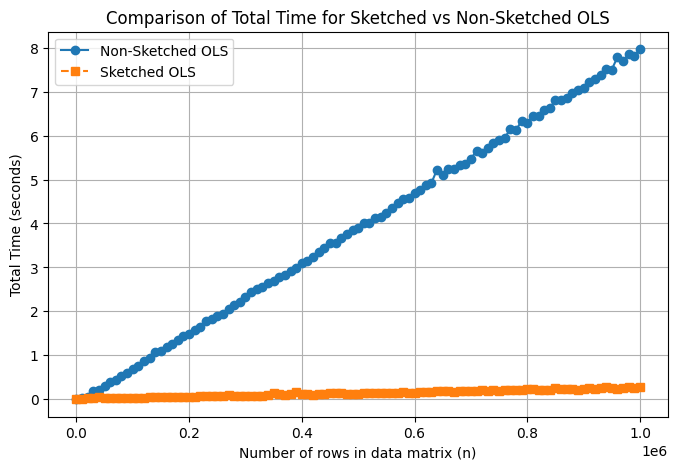

In [40]:
# Extract relevant columns
n_values_non_sketch = non_sketch_nplstq_varying_n_df["n"]
time_non_sketch = non_sketch_nplstq_varying_n_df["time"]

n_values_sketch = fast_sketched_nplstq_varying_n_df["n"]
time_sketch = fast_sketched_nplstq_varying_n_df["total time"]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_values_non_sketch, time_non_sketch, label="Non-Sketched OLS", marker="o")
plt.plot(n_values_sketch, time_sketch, label="Sketched OLS", marker="s", linestyle="dashed")

# Labels and Title
plt.xlabel("Number of rows in data matrix (n)")
plt.ylabel("Total Time (seconds)")
plt.title("Comparison of Total Time for Sketched vs Non-Sketched OLS")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

#### Changing data matrix dimension (d)

##### Non Sketched

In [12]:
#Feature matrix
n = 1000000
d_values = list(range(10,500 + 1, 10))

results = []

for d in d_values:
    
    X = np.random.randn(n, d)

    #True coefficients
    true_x_coefficient = np.random.randn(d)

    #target vector
    y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level
    
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(X, y, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    
    results.append({'d': d, 'time': iteration_time, 'x_estimate' : x_estimate})
non_sketch_nplstq_varying_d_df = pd.DataFrame(results)

In [13]:
non_sketch_nplstq_varying_d_df

,d,time,x_estimate
0,10,0.181489,"[0.22588375461792295, 2.1651732812132174, 0.27..."
1,20,0.642364,"[0.7677811769085634, 0.2480309130999429, 0.627..."
2,30,0.910398,"[1.867642462503047, 0.5660704763592923, 0.2637..."
3,40,1.504734,"[0.32290398195050846, -0.22238745601918525, -0..."
4,50,2.434994,"[1.0468202906704611, -3.104144439306915, 1.752..."
5,60,3.041735,"[-1.2126651984200116, 0.25353474276449095, -0...."
6,70,3.980826,"[1.0321369374017924, 0.5718580564371131, 0.981..."
7,80,5.173530,"[0.49740829956259397, 0.4402897916394761, 0.39..."
8,90,6.166334,"[-0.7704125997186551, -0.8031514834484839, -0...."
9,100,7.417102,"[-2.0581648613735406, 0.17047023642526637, 0.2..."


##### Sketched

In [14]:
results = []
m = 2000
# non_zero_entries = 1 #default 1 for fast sketch

for d in d_values:

    X = np.random.randn(n, d)

    #True coefficients
    true_x_coefficient = np.random.randn(d)

    #target vector
    y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

    start_time = time.time()
    S = fast_sketch_matrix(m, n)
    SX = S @ X
    SY = S @ y
    
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'d': d, 'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate})

fast_sketched_nplstq_varying_d_df = pd.DataFrame(results)

In [15]:
fast_sketched_nplstq_varying_d_df

,d,total time,iteration time,sketch time,x_estimate
0,10,0.083652,0.000000,0.083652,"[0.5888141782800067, 1.115033478522651, 1.1027..."
1,20,0.083669,0.000000,0.083669,"[1.2793465229327152, -1.3936954469350242, -1.0..."
2,30,0.099186,0.003644,0.095542,"[-0.09519062458650358, -0.7477047030250004, 1...."
3,40,0.112042,0.000000,0.112042,"[-0.9641676082514364, -1.5905713474612417, 0.5..."
4,50,0.136196,0.008431,0.127765,"[1.105882621076789, -0.43479496559768804, 0.10..."
5,60,0.164072,0.020928,0.143143,"[-1.2861057742734374, -2.459808754177968, -0.9..."
6,70,0.225556,0.013713,0.211843,"[0.6862967001470904, -0.5189630697268525, 0.09..."
7,80,0.234871,0.029684,0.205187,"[-1.562013675358707, -0.3691455644721696, 0.00..."
8,90,0.248148,0.000671,0.247477,"[-1.4937468329972572, -1.2630790602884607, 1.3..."
9,100,0.288946,0.028204,0.260742,"[-0.8696323336712013, -0.01170116985149483, 0...."


Visualisation of data

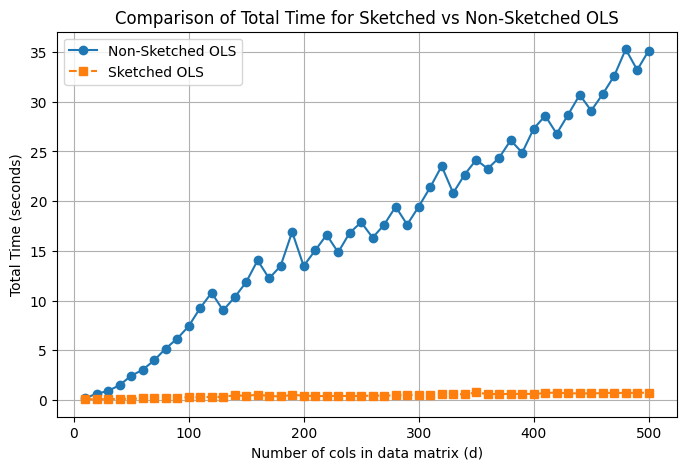

In [17]:
# Extract relevant columns
d_values_non_sketch = non_sketch_nplstq_varying_d_df["d"]
time_non_sketch = non_sketch_nplstq_varying_d_df["time"]

d_values_sketch = fast_sketched_nplstq_varying_d_df["d"]
time_sketch = fast_sketched_nplstq_varying_d_df["total time"]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(d_values_non_sketch, time_non_sketch, label="Non-Sketched OLS", marker="o")
plt.plot(d_values_sketch, time_sketch, label="Sketched OLS", marker="s", linestyle="dashed")

# Labels and Title
plt.xlabel("Number of cols in data matrix (d)")
plt.ylabel("Total Time (seconds)")
plt.title("Comparison of Total Time for Sketched vs Non-Sketched OLS")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

Takeaway: sketched is almost always faster in the case of well conditioned data matrix

In [231]:
#Feature matrix
n = 1000000
d = 20
X = np.random.randn(n, d)

#True coefficients
true_x_coefficient = np.random.randn(d)

#target vector
y = X @ true_x_coefficient + np.random.randn(n) * 0.1 # noise level

non sketched

In [15]:
# Run the function 10 times and collect data
results = []
for i in range(10):
    x, intercept, qr_time, iteration_times, total_time = fast_least_squares_sgd_with_intercept_no_sketch(X, y)
    y_pred = X @ x + intercept
    mse = mean_squared_error(y_pred , y)
    results.append({
        'Iteration': i+1,
        'QR Decomposition Time': qr_time,
        'Total Time': total_time,
        'Number of SGD Steps': len(iteration_times),
        'Average Time per SGD Step': np.mean(iteration_times),
        'mse': mse
    })

# Create DataFrame
sgd_nonsketched_df = pd.DataFrame(results)

In [16]:
sgd_nonsketched_df.head()

,Iteration,QR Decomposition Time,Total Time,Number of SGD Steps,Average Time per SGD Step,mse
0,1,1.787400,13.198605,1000,0.009791,29.228304
1,2,1.637883,12.269919,1000,0.009142,22.505430
2,3,1.640571,12.261818,1000,0.008806,25.712597
3,4,1.556850,11.731256,1000,0.008698,32.679670
4,5,1.593974,11.886541,1000,0.008650,28.762259


In [23]:
avg_sgd_nonsketched_df = sgd_nonsketched_df.mean()

In [24]:
avg_sgd_nonsketched_df

Iteration                       5.500000
QR Decomposition Time           1.625825
Total Time                     12.725116
Number of SGD Steps          1000.000000
Average Time per SGD Step       0.009438
mse                            30.033521
dtype: float64

fast sketched

In [17]:
# Run the function 10 times and collect data
results = []
m = 2000
for i in range(10):
    x, intercept, qr_time, iteration_times,sketching_time ,total_time = fast_least_squares_sgd_analysis(X, y, m)
    y_pred = X @ x + intercept
    mse = mean_squared_error(y_pred , y)
    results.append({
        'Iteration': i+1,
        'QR Decomposition Time': qr_time,
        'Sketching Time': sketching_time,
        'Total Time': total_time,
        'Number of SGD Steps': len(iteration_times),
        'Average Time per SGD Step': np.mean(iteration_times),
        'mse': mse
    })

# Create DataFrame
sgd_fastsketched_df = pd.DataFrame(results)

In [18]:
sgd_fastsketched_df

,Iteration,QR Decomposition Time,Sketching Time,Total Time,Number of SGD Steps,Average Time per SGD Step,mse
0,1,0.000598,0.130272,10.969650,1000,0.009133,37.204001
1,2,0.002997,0.129373,10.851775,1000,0.008973,45.818176
2,3,0.015454,0.078443,10.662402,1000,0.008943,31.086980
3,4,0.000000,0.085546,12.171310,1000,0.010388,46.726647
4,5,0.006414,0.103130,10.873246,1000,0.009032,39.905290
5,6,0.000529,0.081896,10.569291,1000,0.008855,27.442160
6,7,0.000000,0.111615,11.195873,1000,0.009458,40.845860
7,8,0.000000,0.083326,10.413333,1000,0.008704,45.195890
8,9,0.000000,0.081237,11.036372,1000,0.009298,26.987040
9,10,0.002840,0.088561,11.555788,1000,0.009715,33.305012


In [25]:
avg_sgd_fastsketched_df = sgd_fastsketched_df.mean()

In [26]:
avg_sgd_fastsketched_df

Iteration                       5.500000
QR Decomposition Time           0.002883
Sketching Time                  0.097340
Total Time                     11.029904
Number of SGD Steps          1000.000000
Average Time per SGD Step       0.009250
mse                            37.451706
dtype: float64

sketch with 5 sparsity

In [21]:
# Run the function 10 times and collect data
results = []
non_zero_entry = 5
m = 2000
for i in range(10):
    x, intercept, qr_time, iteration_times,sketching_time ,total_time = sketch_least_squares_sgd_analysis(X, y, m, non_zero_entry)
    y_pred = X @ x + intercept
    mse = mean_squared_error(y_pred , y)
    results.append({
        'Iteration': i+1,
        'QR Decomposition Time': qr_time,
        'Sketching Time': sketching_time,
        'Total Time': total_time,
        'Number of SGD Steps': len(iteration_times),
        'Average Time per SGD Step': np.mean(iteration_times),
        'mse': mse
    })

# Create DataFrame
sgd_sketched_df = pd.DataFrame(results)

In [22]:
sgd_sketched_df

,Iteration,QR Decomposition Time,Sketching Time,Total Time,Number of SGD Steps,Average Time per SGD Step,mse
0,1,0.069016,94.136961,109.188671,1000,0.010871,38.368430
1,2,0.052472,103.083298,117.630560,1000,0.011054,25.227743
2,3,0.032912,91.500060,106.904736,1000,0.010784,51.772792
3,4,0.051474,88.364615,103.360181,1000,0.011125,43.994135
4,5,0.061191,94.468780,112.888346,1000,0.012047,40.541124
5,6,0.133627,95.700526,114.576833,1000,0.011302,24.125543
6,7,0.032994,91.924952,106.554222,1000,0.010722,17.373181
7,8,0.058316,87.604533,103.492494,1000,0.010779,30.913630
8,9,0.094434,91.010306,106.134481,1000,0.011100,18.929492
9,10,0.033055,91.219198,105.678146,1000,0.010418,41.309794


In [27]:
avg_sgd_sketched_df = sgd_sketched_df.mean()

In [28]:
avg_sgd_sketched_df

Iteration                       5.500000
QR Decomposition Time           0.061949
Sketching Time                 92.901323
Total Time                    108.640867
Number of SGD Steps          1000.000000
Average Time per SGD Step       0.011020
mse                            33.255586
dtype: float64

## Initialise ill conditioned data matrix

In [ ]:
n = 100000  # Number of samples
d = 200   # Number of features

true_w = np.random.randn(d)
#condition_number = 1e16

# Create matrix with exact condition number
#X = create_ill_conditioned_matrix(n, d, condition_number)
X = np.random.randn(n, d)
X[:10] *= 10000   # First 10 rows scaled by 10000
X[10:20] *= 50000  # Next 10 rows scaled by 5000
X[20:30] *= 20000  # Next 10 rows scaled by 2000

# Add noise to responses
y = X @ true_w + np.random.randn(n) * 0.1

In [46]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)

In [47]:
row_norms = np.linalg.norm(U, axis=1)
row_norms

array([0.99999703, 0.99999716, 0.9999973 , ..., 0.04024562, 0.04275324,
       0.04087255])

In [183]:
# Compute row norms
row_norms = np.linalg.norm(X, axis=1)

# Check statistics
mean_norm = np.mean(row_norms)
std_norm = np.std(row_norms)

print(f"Mean row norm: {mean_norm:.2f}")
print(f"Standard deviation of row norms: {std_norm:.2f}")


Mean row norm: 127.27
Standard deviation of row norms: 7729.05


Visualisation

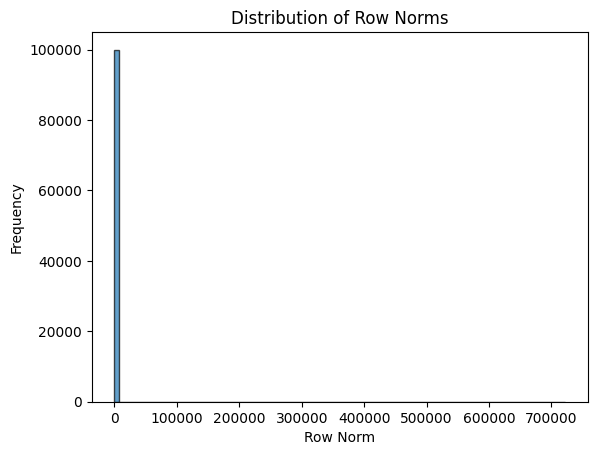

In [184]:

# Plot histogram of row norms
plt.hist(row_norms, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("Row Norm")
plt.ylabel("Frequency")
plt.title("Distribution of Row Norms")
plt.show()

### Train test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
result = []  # List to store results
non_zero_list = list(range(5, 51, 5))  # Values for non-zero entries in S

for s in non_zero_list:
    S = sketch_matrix(2000, n, s)  # Create sketch matrix with 's' non-zero entries per row
    SU = S @ U  # Apply sketching to U
    min_svd, max_svd = compute_min_max_svd(SU)  # Compute min & max SVD values
    # Append results as a dictionary
    result.append({"Non-Zero Entries": s, "Min SVD": min_svd, "Max SVD": max_svd})

# Convert to DataFrame
df = pd.DataFrame(result)

In [60]:
df['min_svd_error'] = abs(1 - df["Min SVD"])
df["max_svd_error"] = abs(1 - df["Max SVD"])
df['sketching_error'] = df[["min_svd_error", "max_svd_error"]].max(axis=1)

In [61]:
df.head()

,Non-Zero Entries,Min SVD,Max SVD,min_svd_error,max_svd_error,sketching_error
0,5,0.692124,1.307145,0.307876,0.307145,0.307876
1,10,0.690683,1.315176,0.309317,0.315176,0.315176
2,15,0.685088,1.317909,0.314912,0.317909,0.317909
3,20,0.694545,1.301272,0.305455,0.301272,0.305455
4,25,0.686844,1.316718,0.313156,0.316718,0.316718


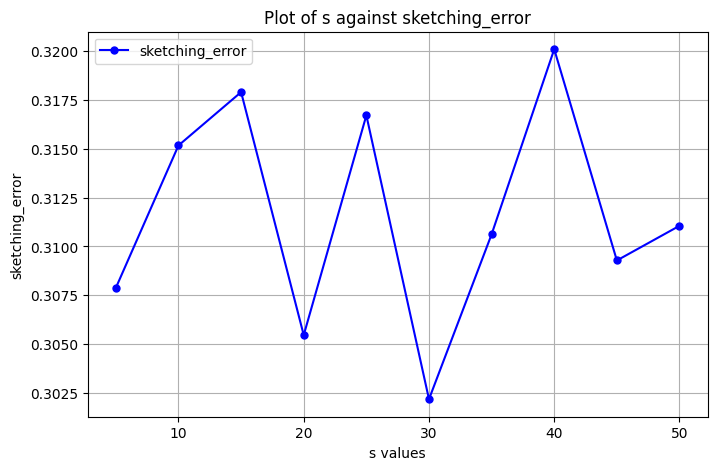

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(df["Non-Zero Entries"], df["sketching_error"], marker='o', linestyle='-', color='b', markersize=5, label='sketching_error')

# Labels and title
plt.xlabel("s values")
plt.ylabel("sketching_error")
plt.title("Plot of s against sketching_error")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [63]:
result = []  # List to store results
non_zero_list = list(range(1, 5, 1))  # Values for non-zero entries in S

for s in non_zero_list:
    S = sketch_matrix(2000, n, s)  # Create sketch matrix with 's' non-zero entries per row
    SU = S @ U  # Apply sketching to U
    min_svd, max_svd = compute_min_max_svd(SU)  # Compute min & max SVD values
    # Append results as a dictionary
    result.append({"Non-Zero Entries": s, "Min SVD": min_svd, "Max SVD": max_svd})

# Convert to DataFrame
df2 = pd.DataFrame(result)

In [64]:
df2['min_svd_error'] = abs(1 - df2["Min SVD"])
df2["max_svd_error"] = abs(1 - df2["Max SVD"])
df2['sketching_error'] = df2[["min_svd_error", "max_svd_error"]].max(axis=1)

In [66]:
df2.head()

,Non-Zero Entries,Min SVD,Max SVD,min_svd_error,max_svd_error,sketching_error
0,1,0.001101,1.488396,0.998899,0.488396,0.998899
1,2,0.690376,1.301990,0.309624,0.301990,0.309624
2,3,0.687136,1.317816,0.312864,0.317816,0.317816
3,4,0.695515,1.312182,0.304485,0.312182,0.312182


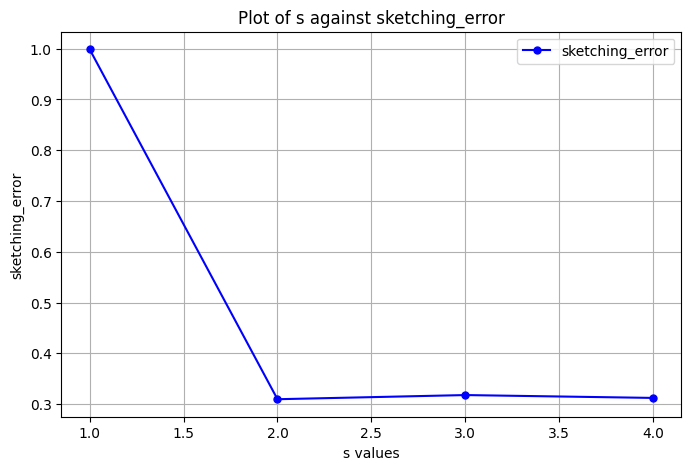

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(df2["Non-Zero Entries"], df2["sketching_error"], marker='o', linestyle='-', color='b', markersize=5, label='sketching_error')

# Labels and title
plt.xlabel("s values")
plt.ylabel("sketching_error")
plt.title("Plot of s against sketching_error")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [68]:
iterations = 1
results = []
m = 2000
non_zero_entries_list = list(range(1,5, 1))

for non_zero_entries in non_zero_entries_list:
    start_time = time.time()  # Start time for sketching process
    
    # Generate sketch matrix S
    S = sketch_matrix(m, n, non_zero_entries)
    
    # Sketched matrices
    SX = S @ X  # Sketched feature matrix
    SY = S @ y  # Sketched response vector
    
    # Calculate SVD of SX to get min/max SVD values (useful for analysis)
    U, S_svd, Vt = np.linalg.svd(SX)
    min_svd = np.min(S_svd)
    max_svd = np.max(S_svd)
    
    # Compute closed-form solution using the sketched matrices (SX, SY)
    beta_sketch = np.linalg.inv(SX.T @ SX) @ SX.T @ SY  # Sketched closed-form solution
    
    # Time taken for sketching step
    sketch_time = time.time() - start_time
    start_time = time.time()  # Reset time for iteration step
    
    # Using least squares with the sketched matrix for comparison
    x_estimate, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
    
    # Time taken for least squares computation
    end_time = time.time()
    iteration_time = end_time - start_time
    
    # Total time for both sketching and iteration steps
    total_time = iteration_time + sketch_time
    
    # Compute Mean Squared Error (MSE) for the estimated x
    mse = np.mean(((X @ x_estimate) - y)**2)
    
    # Append the results
    results.append({
        'non_zero_entries': non_zero_entries,
        'min_svd': min_svd,
        'max_svd': max_svd,
        'total_time': total_time,
        'iteration_time': iteration_time,
        'sketch_time': sketch_time,
        'x_estimate': x_estimate,
        'mse': mse
    })

# Convert results to DataFrame
ill_sketched_nplstq_df = pd.DataFrame(results)


In [69]:
ill_sketched_nplstq_df

,non_zero_entries,min_svd,max_svd,total_time,iteration_time,sketch_time,x_estimate,mse
0,1,221.559875,828653.608701,19.456497,0.094978,19.361518,"[1.2723049021356592, -0.691903566909201, -0.92...",0.011108
1,2,222.568446,828549.519123,17.306183,0.116831,17.189352,"[1.277140231728194, -0.689926714494859, -0.926...",0.011011
2,3,224.077283,899104.323736,18.232488,0.104531,18.127957,"[1.2780273540689113, -0.6930782313538332, -0.9...",0.010892
3,4,223.163292,828644.920904,14.828635,0.102022,14.726613,"[1.2751797196320178, -0.6898493259541735, -0.9...",0.011144


In [56]:
max_svd

1.219764310354701

In [57]:
min_svd_error = abs(1-min_svd)
max_svd_error = abs(1 - max_svd)
print(min_svd_error)
print(max_svd_error)

0.2197852982394406
0.2197643103547009


In [58]:
sketching_error = max(min_svd_error,max_svd_error)
sketching_error

0.2197852982394406

### Non sketched

In [186]:
iterations = 1
results = []

for i in range(iterations):
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(X_train, y_train, rcond=None)
    end_time = time.time()
    mse = np.mean(((X_test @ x_estimate) - y_test)**2)
    iteration_time = end_time - start_time
    
    results.append({'time': iteration_time, 'x_estimate' : x_estimate, 'mse' : mse})
ill_non_sketch_nplstq_df = pd.DataFrame(results)

In [187]:
ill_non_sketch_nplstq_df

,time,x_estimate,mse
0,0.874952,"[0.5892098272149211, -1.1397674881356898, -0.5...",0.477732


### Sketched

In [ ]:
iterations = 10
results = []
m = 2000
#non_zero_entries = 1 default 1 for fast sketch

for i in range(iterations):
    start_time = time.time()
    n,d = X
    S = fast_sketch_matrix(m, n)
    min_svd, max_svd = compute_min_max_svd(SX)
    SX = S @ X_train
    SY = S @ y_train
    
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    mse = np.mean(((X_test @ x_estimate) - y_test)**2)
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'Iteration': i,'min_svd' : min_svd, 'max_svd' : max_svd ,'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate , 'mse' : mse})

ill_fast_sketched_nplstq_df = pd.DataFrame(results)

In [43]:
ill_fast_sketched_nplstq_df

,Iteration,min_svd,max_svd,total time,iteration time,sketch time,x_estimate,mse
0,0,198.608199,855550.832220,0.258035,0.086643,0.171392,"[-0.06521105484813482, 0.4366416433849023, -0....",101.037198
1,1,198.855102,855556.118742,0.298645,0.094950,0.203696,"[-0.06670487686773378, 0.43718518665505157, -0...",96.096482
2,2,201.249365,855557.549845,0.285477,0.105991,0.179487,"[-0.07024178682141768, 0.435846779897884, -0.1...",3.774142
3,3,198.707332,855554.414988,0.449598,0.151573,0.298025,"[-0.0660901644178215, 0.4402498904525006, -0.1...",12.818272
4,4,198.976470,855545.918537,0.341894,0.097724,0.244170,"[-0.06800033181118367, 0.43679487389775573, -0...",71.046019
5,5,198.479492,855539.878082,0.316546,0.099796,0.216750,"[-0.06577632418850539, 0.4365465967708666, -0....",62.175110
6,6,199.652327,855562.015492,0.299838,0.114966,0.184872,"[-0.06261305649933975, 0.4386112373100589, -0....",6.569593
7,7,199.241978,855552.840309,0.259252,0.091175,0.168077,"[-0.06388310378542432, 0.4411558450165812, -0....",0.469589
8,8,197.597264,855566.076959,0.268119,0.098352,0.169767,"[-0.0676605977524242, 0.4392723143399422, -0.1...",52.536297
9,9,199.261886,855538.491463,0.283867,0.094475,0.189392,"[-0.06876162975691692, 0.43661452902950726, -0...",14.222029


In [ ]:
iterations = 1
results = []
m = 2000
non_zero_entries_list = list(range(5,301, 5))

for non_zero_entries in non_zero_entries_list:
    start_time = time.time()
    n,d = X_train
    S = sketch_matrix(m, n, non_zero_entries)
    SX = S @ X
    SY = S @ y
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    mse = np.mean(((X @ x_estimate) - y)**2)
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'non zero entries' : non_zero_entries,'min_svd' : min_svd, 'max_svd' : max_svd, 'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate , 'mse' : mse})

ill_sketched_nplstq_df = pd.DataFrame(results)

In [210]:
ill_sketched_nplstq_df.head()

,non zero entries,total time,iteration time,sketch time,x_estimate,mse
0,5,5.744967,0.059780,5.685187,"[0.589081474052442, -1.1435629870342956, -0.58...",44.485278
1,10,5.451105,0.047497,5.403608,"[0.5865116044611913, -1.1397839168569914, -0.5...",54.163391
2,15,5.521485,0.046447,5.475038,"[0.5899157992511002, -1.1411230300672888, -0.5...",8.686367
3,20,5.468430,0.045407,5.423023,"[0.5877511291135914, -1.1404425089478318, -0.5...",9.562739
4,25,5.577095,0.045793,5.531302,"[0.5880555012536852, -1.1365819991299373, -0.5...",2.885180


Visualisation

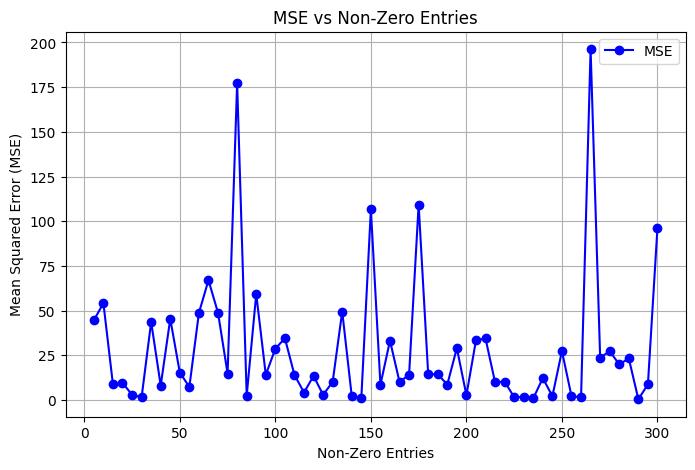

In [212]:
plt.figure(figsize=(8, 5))
plt.plot(ill_sketched_nplstq_df["non zero entries"], ill_sketched_nplstq_df["mse"], marker="o", linestyle="-", color="b", label="MSE")

# Labels and title
plt.xlabel("Non-Zero Entries")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Non-Zero Entries")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### SGD non sketched

In [51]:
iterations = 1
results = []

for i in range(iterations):
    x_estimate , intercept, qr_time, mini_batch_time, total_time = fast_least_squares_sgd_with_intercept_no_sketch(X_train,y_train)
    print("Shape of x_estimate:", x_estimate.shape)
    print("Shape of intercept:", np.shape(intercept))
    print(intercept)
    print("Shape of X_test @ x_estimate:", (X_test @ x_estimate).shape)
    mse = np.mean(((X_test @ x_estimate) + intercept - y_test)**2)
    
    results.append({'total time': total_time,'QR_time' : qr_time, 'mini batch time' : mini_batch_time ,  'x_estimate' : x_estimate, 'intercept' : intercept, 'mse' : mse})

ill_fast_non_sketched_SGD_df = pd.DataFrame(results)

Shape of x_estimate: (200,)
Shape of intercept: ()
0.35127410705272544
Shape of X_test @ x_estimate: (20000,)


In [53]:
ill_fast_non_sketched_SGD_df

,total time,QR_time,mini batch time,x_estimate,intercept,mse
0,3.520297,2.001797,"[-1740807805.5891416, -1740807805.5874445, -17...","[-0.4841270728933154, 0.41411055951635545, 0.1...",0.351274,1.855533e+15


#### SGD Sketched

In [89]:
iterations = 1
results = []
m = 2000
non_zero_entries_list = list(range(1, 50))

for non_zero_entries in non_zero_entries_list:
    x_estimate , intercept, qr_time, mini_batch_time, sketching_time ,total_time = sketch_least_squares_sgd_analysis(X_train,y_train,m , non_zero_entries )
    mse = np.mean(((X_test @ x_estimate) + intercept - y_test)**2)
    results.append({'non zero entries' : non_zero_entries, 'total time': total_time,'QR_time' : qr_time, 'mini batch time' : mini_batch_time ,'Sketching time' : sketching_time , 'x_estimate' : x_estimate, 'intercept' : intercept, 'mse' : mse})

ill_sketched_SGD_df = pd.DataFrame(results)


C:\Users\lakbo\AppData\Local\Temp\ipykernel_27768\528350053.py:41: RuntimeWarning: overflow encountered in matmul
  gt = 2 * StA.T @ (StA @ x - Stb)
C:\Users\lakbo\AppData\Local\Temp\ipykernel_27768\528350053.py:41: RuntimeWarning: invalid value encountered in matmul
  gt = 2 * StA.T @ (StA @ x - Stb)
C:\Users\lakbo\AppData\Local\Temp\ipykernel_27768\528350053.py:44: RuntimeWarning: invalid value encountered in matmul
  x = x - eta * R @ (R.T @ gt)


In [90]:
ill_sketched_SGD_df

,non zero entries,total time,QR_time,mini batch time,Sketching time,x_estimate,intercept,mse
0,1,8.219342,0.214488,"[-1740807806.273785, -1740807806.2723308, -174...",5.296986,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
1,2,7.781811,0.072011,"[-1740807807.2033632, -1740807807.2020817, -17...",5.849793,"[-13172.73957623593, 77436.58983295172, 145591...",37583.478543,1.254727e+25
2,3,6.983228,0.111910,"[-1740807807.2682674, -1740807807.266691, -174...",5.145567,"[-203077.81822887785, 245932.90713405778, -117...",-50950.433027,8.885356e+24
3,4,6.975704,0.079965,"[-1740807807.3052585, -1740807807.3036795, -17...",5.180312,"[-18975.879519414957, -218910.01528861516, -97...",-38911.301177,3.403595e+25
4,5,6.944452,0.085681,"[-1740807807.3232548, -1740807807.3217926, -17...",5.165312,"[-36865.05732228311, -152643.42820221436, -16....",66952.052212,1.206124e+25
5,6,7.096572,0.070582,"[-1740807807.2839208, -1740807807.28254, -1740...",5.284618,"[-35356.82347385209, 35171.01723901288, -80298...",-196109.917767,1.792262e+25
6,7,7.200154,0.074524,"[-1740807807.2159445, -1740807807.2147636, -17...",5.317530,"[241270.30538010047, -31483.70106347774, 26284...",-66847.644442,2.836457e+25
7,8,7.301816,0.082884,"[-1740807807.2398365, -1740807807.2380428, -17...",5.437868,"[-69982.7020307205, -114955.92277123894, -2217...",104723.223113,2.434084e+25
8,9,7.463210,0.133427,"[-1740807807.1605687, -1740807807.1594427, -17...",5.520630,"[150666.7198271179, -138309.24678079688, 23068...",-239657.207808,1.527620e+25
9,10,7.464367,0.079902,"[-1740807807.232234, -1740807807.230515, -1740...",5.577746,"[-11703.43788749815, 115719.74544755074, -2435...",-82358.526282,7.609722e+24


Visualisation

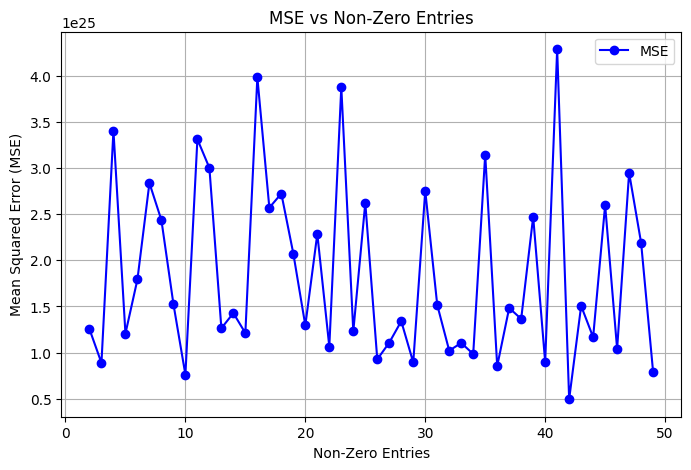

In [91]:
plt.figure(figsize=(8, 5))
plt.plot(ill_sketched_SGD_df["non zero entries"], ill_sketched_SGD_df["mse"], marker="o", linestyle="-", color="b", label="MSE")

# Labels and title
plt.xlabel("Non-Zero Entries")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Non-Zero Entries")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [77]:
iterations = 1
results = []
m = 2000
non_zero_entries_list = list(range(1, 21))

for non_zero_entries in non_zero_entries_list:
    x_estimate , intercept, _, qr_time, mini_batch_time, sketching_time ,total_time = fast_least_squares_sgd_regularized_analysis(X_train,y_train, non_zero_entries, m )
    mse = np.mean(((X_test @ x_estimate) + intercept - y_test)**2)
    results.append({'non zero entries' : non_zero_entries, 'total time': total_time,'QR_time' : qr_time, 'mini batch time' : mini_batch_time ,'Sketching time' : sketching_time , 'x_estimate' : x_estimate, 'intercept' : intercept, 'mse' : mse})

ill_sketched_SGD_reg_df = pd.DataFrame(results)


C:\Users\lakbo\AppData\Local\Temp\ipykernel_27768\2602092633.py:45: RuntimeWarning: overflow encountered in matmul
  gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)
C:\Users\lakbo\AppData\Local\Temp\ipykernel_27768\2602092633.py:45: RuntimeWarning: invalid value encountered in matmul
  gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)
C:\Users\lakbo\AppData\Local\Temp\ipykernel_27768\2602092633.py:48: RuntimeWarning: invalid value encountered in matmul
  x = x - eta * R @ (R.T @ gt)


In [78]:
ill_sketched_SGD_reg_df

,non zero entries,total time,QR_time,mini batch time,Sketching time,x_estimate,intercept,mse
0,1,6.638418,0.052120,"[-1740807807.4542277, -1740807807.4526937, -17...",4.876429,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
1,2,6.777384,0.044370,"[-1740807807.5217335, -1740807807.520044, -174...",5.037977,"[38003.811940229476, -107936.5910644353, -2080...",175142.049717,1.052686e+25
2,3,6.858121,0.086028,"[-1740807807.4974003, -1740807807.4957628, -17...",5.130812,"[57169.71319634582, 35180.754647686874, 168275...",208371.179306,2.422555e+25
3,4,6.933859,0.046891,"[-1740807807.5173926, -1740807807.5157256, -17...",5.220328,"[109689.23870176582, -67523.38368513441, 23295...",54889.029379,1.566646e+25
4,5,6.984404,0.042506,"[-1740807807.5119877, -1740807807.510012, -174...",5.252210,"[67402.8470761006, -25234.193805185856, 110152...",-43686.090114,9.149630e+24
5,6,7.691848,0.229835,"[-1740807807.0848234, -1740807807.0831454, -17...",5.555482,"[-36597.12928019982, -17333.29836689935, 61210...",-359049.551969,5.869538e+24
6,7,7.587503,0.069638,"[-1740807807.2352538, -1740807807.2336066, -17...",5.606130,"[106136.72262331164, -487198.9933488448, -9733...",21627.259951,2.756956e+25
7,8,7.484324,0.068056,"[-1740807807.251094, -1740807807.249793, -1740...",5.500923,"[62067.4591035634, -116408.91557926401, 13249....",8204.146877,1.022753e+25
8,9,7.576773,0.154795,"[-1740807807.155916, -1740807807.154195, -1740...",5.444656,"[116382.14326962587, 1138.7499680645913, -1017...",-12273.321863,9.539731e+24
9,10,7.609995,0.070714,"[-1740807807.2767708, -1740807807.275255, -174...",5.554638,"[-91389.00723439983, -101714.23038698068, 9098...",159774.933210,1.368496e+25


# ill conditioned matrix

In [127]:
n = 100000  # Number of samples
d = 200   # Number of features

true_w = np.random.randn(d)
#condition_number = 1e16

# Create matrix with exact condition number
#X = create_ill_conditioned_matrix(n, d, condition_number)
X = np.random.randn(n, d)
X[:100] *= 10000   # First 10 rows scaled by 10000
X[100:200] *= 50000  # Next 10 rows scaled by 5000
X[200:300] *= 20000  # Next 10 rows scaled by 2000

# Add noise to responses
y = X @ true_w + np.random.randn(n) * 10

In [128]:
min_SVD_X, max_SVD_X = compute_min_max_svd(X)

In [129]:
print(min_SVD_X)
print(max_SVD_X)

55050.968393249546
1195412.4112178215


In [130]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)

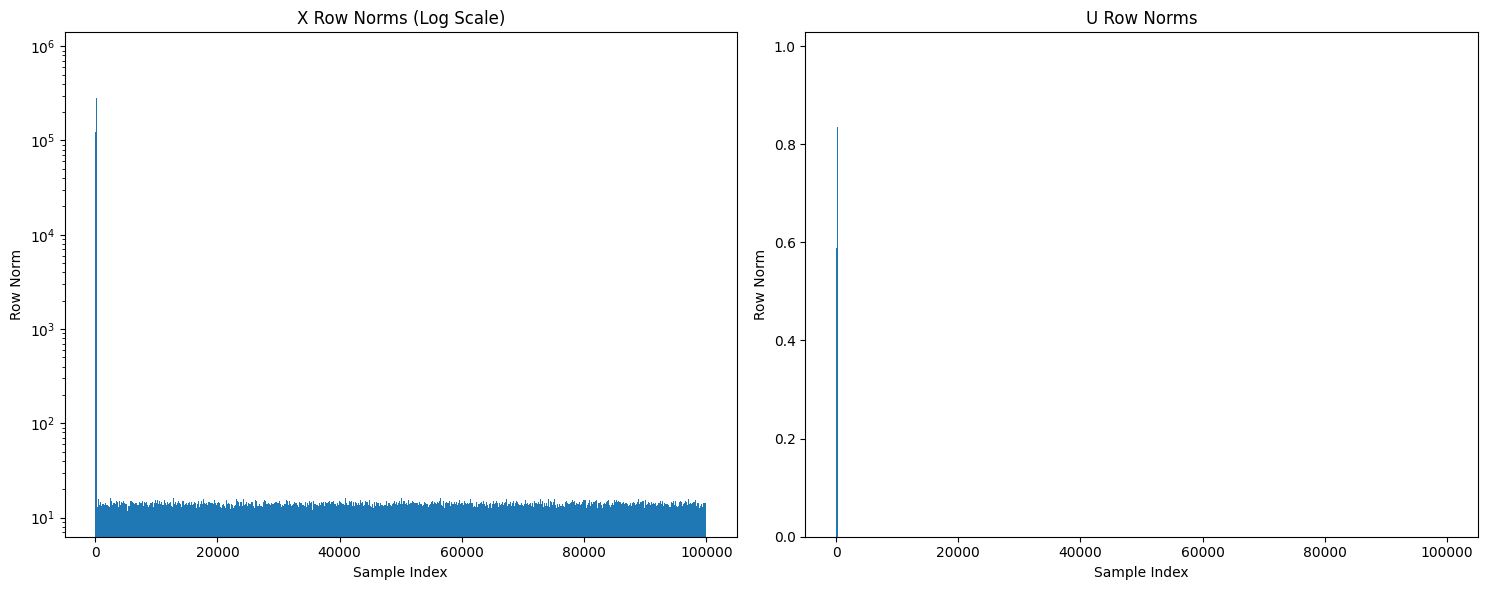

In [131]:
X_row_norms = np.linalg.norm(X, axis=1)
U_row_norms = np.linalg.norm(U, axis=1)

# Create plots
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(range(n), X_row_norms, width=1)
plt.yscale('log')
plt.title('X Row Norms (Log Scale)')
plt.xlabel('Sample Index')
plt.ylabel('Row Norm')

plt.subplot(1, 2, 2)
plt.bar(range(n), U_row_norms, width=1)
plt.title('U Row Norms')
plt.xlabel('Sample Index')
plt.ylabel('Row Norm')

plt.tight_layout()
plt.show()

In [132]:
result = []  # List to store results
non_zero_list = list(range(2, 51, 2))  # Values for non-zero entries in S

for s in non_zero_list:
    S = sketch_matrix(2000, n, s)  # Create sketch matrix with 's' non-zero entries per row
    SU = S @ U  # Apply sketching to U
    min_svd, max_svd = compute_min_max_svd(SU)  # Compute min & max SVD values
    # Append results as a dictionary
    result.append({"Non-Zero Entries": s, "Min SVD": min_svd, "Max SVD": max_svd})

# Convert to DataFrame
df = pd.DataFrame(result)

In [133]:
df['min_svd_error'] = abs(1 - df["Min SVD"])
df["max_svd_error"] = abs(1 - df["Max SVD"])
df['sketching_error'] = df[["min_svd_error", "max_svd_error"]].max(axis=1)

In [134]:
df.head()

,Non-Zero Entries,Min SVD,Max SVD,min_svd_error,max_svd_error,sketching_error
0,2,0.489357,1.447471,0.510643,0.447471,0.510643
1,4,0.637223,1.385636,0.362777,0.385636,0.385636
2,6,0.685223,1.299795,0.314777,0.299795,0.314777
3,8,0.679562,1.317820,0.320438,0.317820,0.320438
4,10,0.684123,1.333608,0.315877,0.333608,0.333608


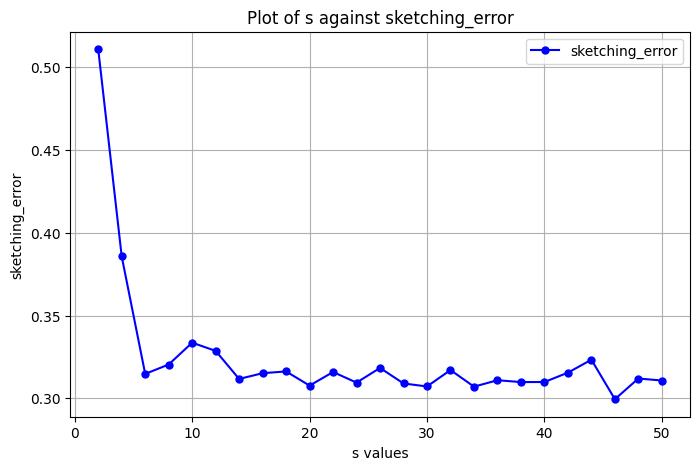

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df["Non-Zero Entries"], df["sketching_error"], marker='o', linestyle='-', color='b', markersize=5, label='sketching_error')

# Labels and title
plt.xlabel("s values")
plt.ylabel("sketching_error")
plt.title("Plot of SU against sketching_error")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [136]:
iterations = 1
results = []

for i in range(iterations):
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(X, y, rcond=None)
    end_time = time.time()
    mse = np.mean(((X @ x_estimate) - y)**2)
    iteration_time = end_time - start_time
    
    results.append({'time': iteration_time, 'x_estimate' : x_estimate, 'mse' : mse})
ill_non_sketch_nplstq_df = pd.DataFrame(results)

In [137]:
ill_non_sketch_nplstq_df

,time,x_estimate,mse
0,1.210675,"[-0.2513826060998359, 0.3905607210925347, -0.1...",99.848331


In [160]:
iterations = 10
results = []
m = 2000

for i in range(iterations):
    start_time = time.time()
    S = fast_sketch_matrix(m, n)
    SX = S @ X
    SY = S @ y
    min_svd, max_svd = compute_min_max_svd(SX)
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    mse = np.mean(((X @ x_estimate) - y)**2)
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'Iteration': i,'min_svd' : min_svd, 'max_svd' : max_svd ,'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate , 'mse' : mse})

ill_fast_sketched_nplstq_df = pd.DataFrame(results)

In [161]:
ill_fast_sketched_nplstq_df['min_svd_error'] = abs(min_SVD_X - ill_fast_sketched_nplstq_df["min_svd"])
ill_fast_sketched_nplstq_df["max_svd_error"] = abs(max_SVD_X - ill_fast_sketched_nplstq_df["max_svd"])
ill_fast_sketched_nplstq_df['sketching_error'] = ill_fast_sketched_nplstq_df[["min_svd_error", "max_svd_error"]].max(axis=1)

In [162]:
ill_fast_sketched_nplstq_df

,Iteration,min_svd,max_svd,total time,iteration time,sketch time,x_estimate,mse,min_svd_error,max_svd_error,sketching_error
0,0,45282.734570,1.278066e+06,0.157094,0.043515,0.113579,"[-0.2512777200422281, 0.3904137848123499, -0.1...",116.415375,9768.233824,82653.473628,82653.473628
1,1,41634.202202,1.334804e+06,0.126943,0.032467,0.094476,"[-0.2519429159210205, 0.3909264135398667, -0.1...",123.004795,13416.766191,139391.320676,139391.320676
2,2,48984.106688,1.279016e+06,0.149489,0.052519,0.096970,"[-0.2516928229046352, 0.3911465417394063, -0.1...",111.662829,6066.861706,83603.585942,83603.585942
3,3,43442.442902,1.272613e+06,0.128576,0.034150,0.094426,"[-0.2516484580276574, 0.39039792737920487, -0....",117.077979,11608.525491,77200.845567,77200.845567
4,4,43130.801209,1.314484e+06,0.143837,0.045115,0.098722,"[-0.2513380368408726, 0.3898431420392173, -0.1...",115.566428,11920.167184,119071.998535,119071.998535
5,5,45678.901108,1.355765e+06,0.144215,0.048411,0.095804,"[-0.2516671572818489, 0.39003600559876234, -0....",117.629453,9372.067286,160352.185856,160352.185856
6,6,46647.113057,1.227409e+06,0.161370,0.063660,0.097710,"[-0.25152295556845794, 0.39042958498676034, -0...",111.102196,8403.855336,31997.064646,31997.064646
7,7,39660.076616,1.332917e+06,0.198182,0.041516,0.156666,"[-0.2510678187105597, 0.3899265875143843, -0.1...",121.152215,15390.891777,137504.702689,137504.702689
8,8,45422.167424,1.238000e+06,0.129318,0.030839,0.098478,"[-0.2514567576713702, 0.3911146137940906, -0.1...",112.339023,9628.800969,42587.515815,42587.515815
9,9,46959.822048,1.263760e+06,0.143419,0.046307,0.097112,"[-0.251312762851989, 0.3908206456651855, -0.11...",109.645796,8091.146346,68348.005533,68348.005533


In [163]:
numeric_columns = ill_fast_sketched_nplstq_df.select_dtypes(include=[np.number]).columns
ill_fast_sketched_nplstq_df_avg = ill_fast_sketched_nplstq_df[numeric_columns].mean()

In [164]:
ill_fast_sketched_nplstq_df_avg

Iteration          4.500000e+00
min_svd            4.468424e+04
max_svd            1.289683e+06
total time         1.482443e-01
iteration time     4.384995e-02
sketch time        1.043943e-01
mse                1.155596e+02
min_svd_error      1.036673e+04
max_svd_error      9.427107e+04
sketching_error    9.427107e+04
dtype: float64

In [143]:
iterations = 10
results = []
m = 2000

for i in range(iterations):
    start_time = time.time()
    S = sketch_matrix(m,n,10)
    SX = S @ X
    SY = S @ y
    min_svd, max_svd = compute_min_max_svd(SX)
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    mse = np.mean(((X @ x_estimate) - y)**2)
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'Iteration': i,'min_svd' : min_svd, 'max_svd' : max_svd ,'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate , 'mse' : mse})

ill_sketched_nplstq_df = pd.DataFrame(results)

In [144]:
ill_sketched_nplstq_df['min_svd_error'] = abs(min_SVD_X - ill_sketched_nplstq_df["min_svd"])
ill_sketched_nplstq_df["max_svd_error"] = abs(max_SVD_X - ill_sketched_nplstq_df["max_svd"])
ill_sketched_nplstq_df['sketching_error'] = ill_sketched_nplstq_df[["min_svd_error", "max_svd_error"]].max(axis=1)

In [145]:
ill_sketched_nplstq_df

,Iteration,min_svd,max_svd,total time,iteration time,sketch time,x_estimate,mse,min_svd_error,max_svd_error,sketching_error
0,0,52135.295319,1.270419e+06,7.853173,0.062979,7.790194,"[-0.25099726152424195, 0.3903058090482128, -0....",109.136824,2915.673075,75006.890184,75006.890184
1,1,52323.374507,1.232687e+06,7.738354,0.079079,7.659275,"[-0.25126730980698614, 0.3907418440745904, -0....",110.974822,2727.593887,37274.138770,37274.138770
2,2,51378.709564,1.232839e+06,8.836269,0.062631,8.773638,"[-0.2513944422475713, 0.3902234907518467, -0.1...",109.039038,3672.258829,37426.495420,37426.495420
3,3,51908.231807,1.218370e+06,8.232568,0.063329,8.169240,"[-0.25165311934170687, 0.39047016513276617, -0...",110.412733,3142.736586,22957.510241,22957.510241
4,4,53063.596574,1.222052e+06,9.767494,0.072943,9.694551,"[-0.25155966610229374, 0.3904326184334588, -0....",110.081039,1987.371820,26639.647759,26639.647759
5,5,51156.349331,1.229460e+06,9.144660,0.067117,9.077543,"[-0.2520172227145625, 0.3904843223773427, -0.1...",110.713548,3894.619063,34047.738609,34047.738609
6,6,53012.741286,1.203556e+06,7.601847,0.059952,7.541895,"[-0.25156231896305575, 0.3908512844831492, -0....",111.954868,2038.227107,8144.016509,8144.016509
7,7,51576.937410,1.235733e+06,9.453158,0.086267,9.366890,"[-0.2521234587056937, 0.390093315268294, -0.11...",112.642804,3474.030983,40320.735917,40320.735917
8,8,51847.123470,1.229227e+06,8.108068,0.057903,8.050164,"[-0.2515963983353265, 0.39053766369278786, -0....",111.052193,3203.844923,33815.086710,33815.086710
9,9,51335.024106,1.217942e+06,7.466053,0.073233,7.392820,"[-0.251680649142047, 0.3901901891236766, -0.11...",111.901631,3715.944287,22529.756918,22529.756918


In [146]:
numeric_columns = ill_sketched_nplstq_df.select_dtypes(include=[np.number]).columns
ill_sketched_nplstq_df_avg = ill_sketched_nplstq_df[numeric_columns].mean()

In [147]:
ill_sketched_nplstq_df_avg

Iteration          4.500000e+00
min_svd            5.197374e+04
max_svd            1.229229e+06
total time         8.420164e+00
iteration time     6.854334e-02
sketch time        8.351621e+00
mse                1.107909e+02
min_svd_error      3.077230e+03
max_svd_error      3.381620e+04
sketching_error    3.381620e+04
dtype: float64

In [152]:
non_zero_entries = list(range(5,300,5))
results = []
m = 2000

for i in non_zero_entries:
    start_time = time.time()
    S = sketch_matrix(m,n,i)
    SX = S @ X
    SY = S @ y
    min_svd, max_svd = compute_min_max_svd(SX)
    sketch_time = time.time() - start_time
    start_time = time.time()
    x_estimate, _, _ , _ = np.linalg.lstsq(SX, SY, rcond=None)
    end_time = time.time()
    mse = np.mean(((X @ x_estimate) - y)**2)
    iteration_time = end_time - start_time
    total_time = iteration_time + sketch_time
    
    results.append({'Sparsity': i,'min_svd' : min_svd, 'max_svd' : max_svd ,'total time': total_time,'iteration time' : iteration_time, 'sketch time' : sketch_time ,  'x_estimate' : x_estimate , 'mse' : mse})

ill_sketched_nplstq_sparsity_df = pd.DataFrame(results)

In [153]:
ill_sketched_nplstq_sparsity_df['min_svd_error'] = abs(min_SVD_X - ill_sketched_nplstq_sparsity_df["min_svd"])
ill_sketched_nplstq_sparsity_df["max_svd_error"] = abs(max_SVD_X - ill_sketched_nplstq_sparsity_df["max_svd"])
ill_sketched_nplstq_sparsity_df['sketching_error'] = ill_sketched_nplstq_sparsity_df[["min_svd_error", "max_svd_error"]].max(axis=1)

In [154]:
ill_sketched_nplstq_sparsity_df.head()

,Sparsity,min_svd,max_svd,total time,iteration time,sketch time,x_estimate,mse,min_svd_error,max_svd_error,sketching_error
0,5,51738.290284,1.217792e+06,8.744041,0.049904,8.694137,"[-0.2515499820898191, 0.3903403154469458, -0.1...",112.895096,3312.678109,22380.002200,22380.002200
1,10,50453.903475,1.213110e+06,7.354521,0.047192,7.307329,"[-0.25164827577312066, 0.39042772746381504, -0...",110.547541,4597.064918,17697.091508,17697.091508
2,15,53897.682930,1.240823e+06,7.275303,0.043070,7.232233,"[-0.25087070254207783, 0.3899370429004495, -0....",109.436700,1153.285464,45411.083903,45411.083903
3,20,53580.490964,1.236496e+06,7.143658,0.041235,7.102423,"[-0.2519060547198965, 0.3909067521911051, -0.1...",110.149082,1470.477430,41083.899329,41083.899329
4,25,50780.631753,1.248546e+06,7.147185,0.034090,7.113095,"[-0.2520784406071125, 0.39051777981363456, -0....",112.763179,4270.336640,53133.250243,53133.250243


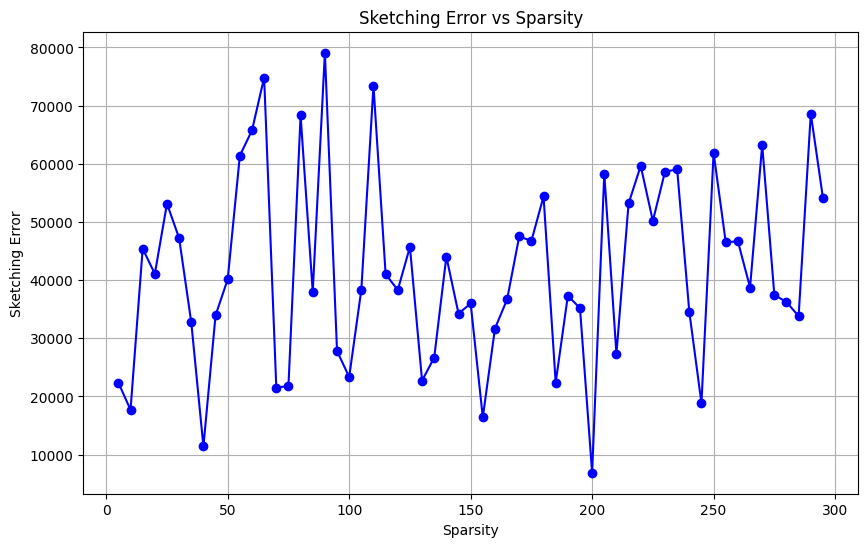

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(ill_sketched_nplstq_sparsity_df['Sparsity'], ill_sketched_nplstq_sparsity_df['sketching_error'], marker='o', linestyle='-', color='b')
plt.xlabel('Sparsity')
plt.ylabel('Sketching Error')
plt.title('Sketching Error vs Sparsity')
plt.grid(True)
plt.show()

20 iterations to get avg

In [ ]:
    non_zero_entries = list(range(5,100,5))
    results = []
    m = 2000

    for i in non_zero_entries:
        iteration_results = []
        for _ in range(20):  # 20 runs for each non-zero entry configuration
            start_time = time.time()
            S = sketch_matrix(m, n, i)  # Use sketch_matrix with non-zero entries
            SX = S @ X
            SY = S @ y
            min_svd, max_svd = compute_min_max_svd(SX)
            sketch_time = time.time() - start_time
            start_time = time.time()
            x_estimate, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
            end_time = time.time()
            mse = np.mean(((X @ x_estimate) - y)**2)
            iteration_time = end_time - start_time
            total_time = iteration_time + sketch_time
            
            iteration_results.append({
                'min_svd': min_svd,
                'max_svd': max_svd,
                'total_time': total_time,
                'iteration_time': iteration_time,
                'sketch_time': sketch_time,
                'mse': mse
            })
        
        # Calculate averages
        avg_result = {
            'Sparsity': i,
            'min_svd': np.mean([r['min_svd'] for r in iteration_results]),
            'max_svd': np.mean([r['max_svd'] for r in iteration_results]),
            'total_time': np.mean([r['total_time'] for r in iteration_results]),
            'iteration_time': np.mean([r['iteration_time'] for r in iteration_results]),
            'sketch_time': np.mean([r['sketch_time'] for r in iteration_results]),
            'mse': np.mean([r['mse'] for r in iteration_results])
        }
        
        results.append(avg_result)

    ill_sketched_nplstq_sparsity_df_iterated = pd.DataFrame(results)

In [170]:
ill_sketched_nplstq_sparsity_df_iterated['min_svd_error'] = abs(min_SVD_X - ill_sketched_nplstq_sparsity_df_iterated["min_svd"])
ill_sketched_nplstq_sparsity_df_iterated["max_svd_error"] = abs(max_SVD_X - ill_sketched_nplstq_sparsity_df_iterated["max_svd"])
ill_sketched_nplstq_sparsity_df_iterated['sketching_error'] = ill_sketched_nplstq_sparsity_df_iterated[["min_svd_error", "max_svd_error"]].max(axis=1)

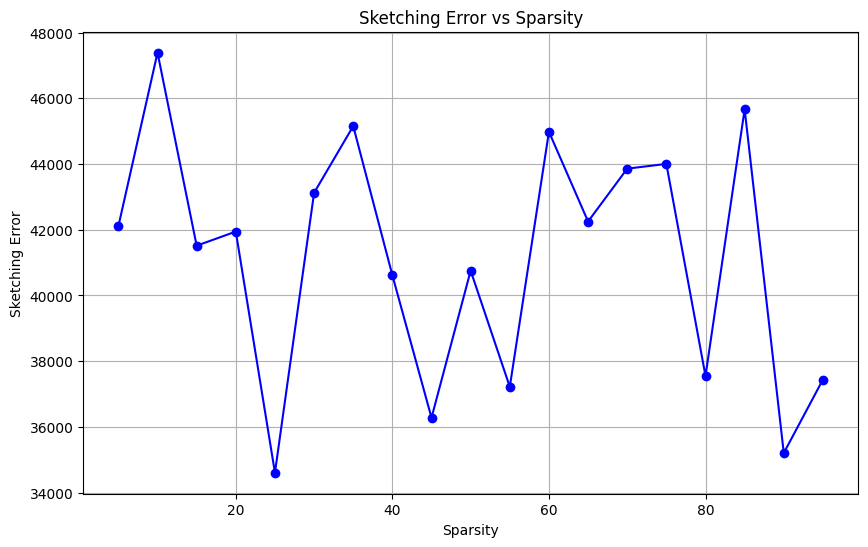

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(ill_sketched_nplstq_sparsity_df_iterated['Sparsity'], ill_sketched_nplstq_sparsity_df_iterated['sketching_error'], marker='o', linestyle='-', color='b')
plt.xlabel('Sparsity')
plt.ylabel('Sketching Error')
plt.title('Sketching Error vs Sparsity')
plt.grid(True)
plt.show()

Varying D on sparsity

In [176]:
n = 10000  # Fixed number of samples
d_values = list(range(10, 300, 10))  # Feature dimensions to test
non_zero_entries = list(range(5, 100, 5))  # Sparsity levels
m = 2000  # Sketch size
results = []
for d in d_values:
    # Generate new true_w and data for each d
    true_w = np.random.randn(d)
    
    # Create data matrix with current d
    X = np.random.randn(n, d)
    X[:100] *= 10000
    X[100:200] *= 50000
    X[200:300] *= 20000
    
    # Generate responses with higher noise
    y = X @ true_w + np.random.randn(n) * 10
    
    # Precompute reference SVD values
    min_SVD_X, max_SVD_X = compute_min_max_svd(X)
    
    for sparsity in non_zero_entries:
        iteration_results = []
        
        # Run 10 iterations per configuration
        for _ in range(5):
            start_time = time.time()
            S = sketch_matrix(m, n, sparsity)
            SX = S @ X
            SY = S @ y
            min_svd, max_svd = compute_min_max_svd(SX)
            sketch_time = time.time() - start_time
            
            # Solve sketched system
            start_time = time.time()
            x_estimate, _, _, _ = np.linalg.lstsq(SX, SY, rcond=None)
            iteration_time = time.time() - start_time
            
            # Calculate metrics
            mse = np.mean(((X @ x_estimate) - y)**2)
            sketch_error_min = abs(min_svd - min_SVD_X)
            sketch_error_max = abs(max_svd - max_SVD_X)
            
            iteration_results.append({
                'sketch_error_min': sketch_error_min,
                'sketch_error_max': sketch_error_max,
                'total_time': iteration_time + sketch_time,
                'mse': mse
            })
        
        # Aggregate results across iterations
        avg_result = {
            'd': d,
            'sparsity': sparsity,
            'avg_min_svd_error': np.mean([r['sketch_error_min'] for r in iteration_results]),
            'avg_max_svd_error': np.mean([r['sketch_error_max'] for r in iteration_results]),
            'avg_mse': np.mean([r['mse'] for r in iteration_results]),
            'avg_total_time': np.mean([r['total_time'] for r in iteration_results]),
            'min_svd_X': min_SVD_X,
            'max_svd_X': max_SVD_X
        }
        
        results.append(avg_result)

# Create final dataframe
results_df = pd.DataFrame(results)

In [177]:
results_df['avg_sketching_error'] = results_df[["avg_min_svd_error", "avg_max_svd_error"]].max(axis=1)

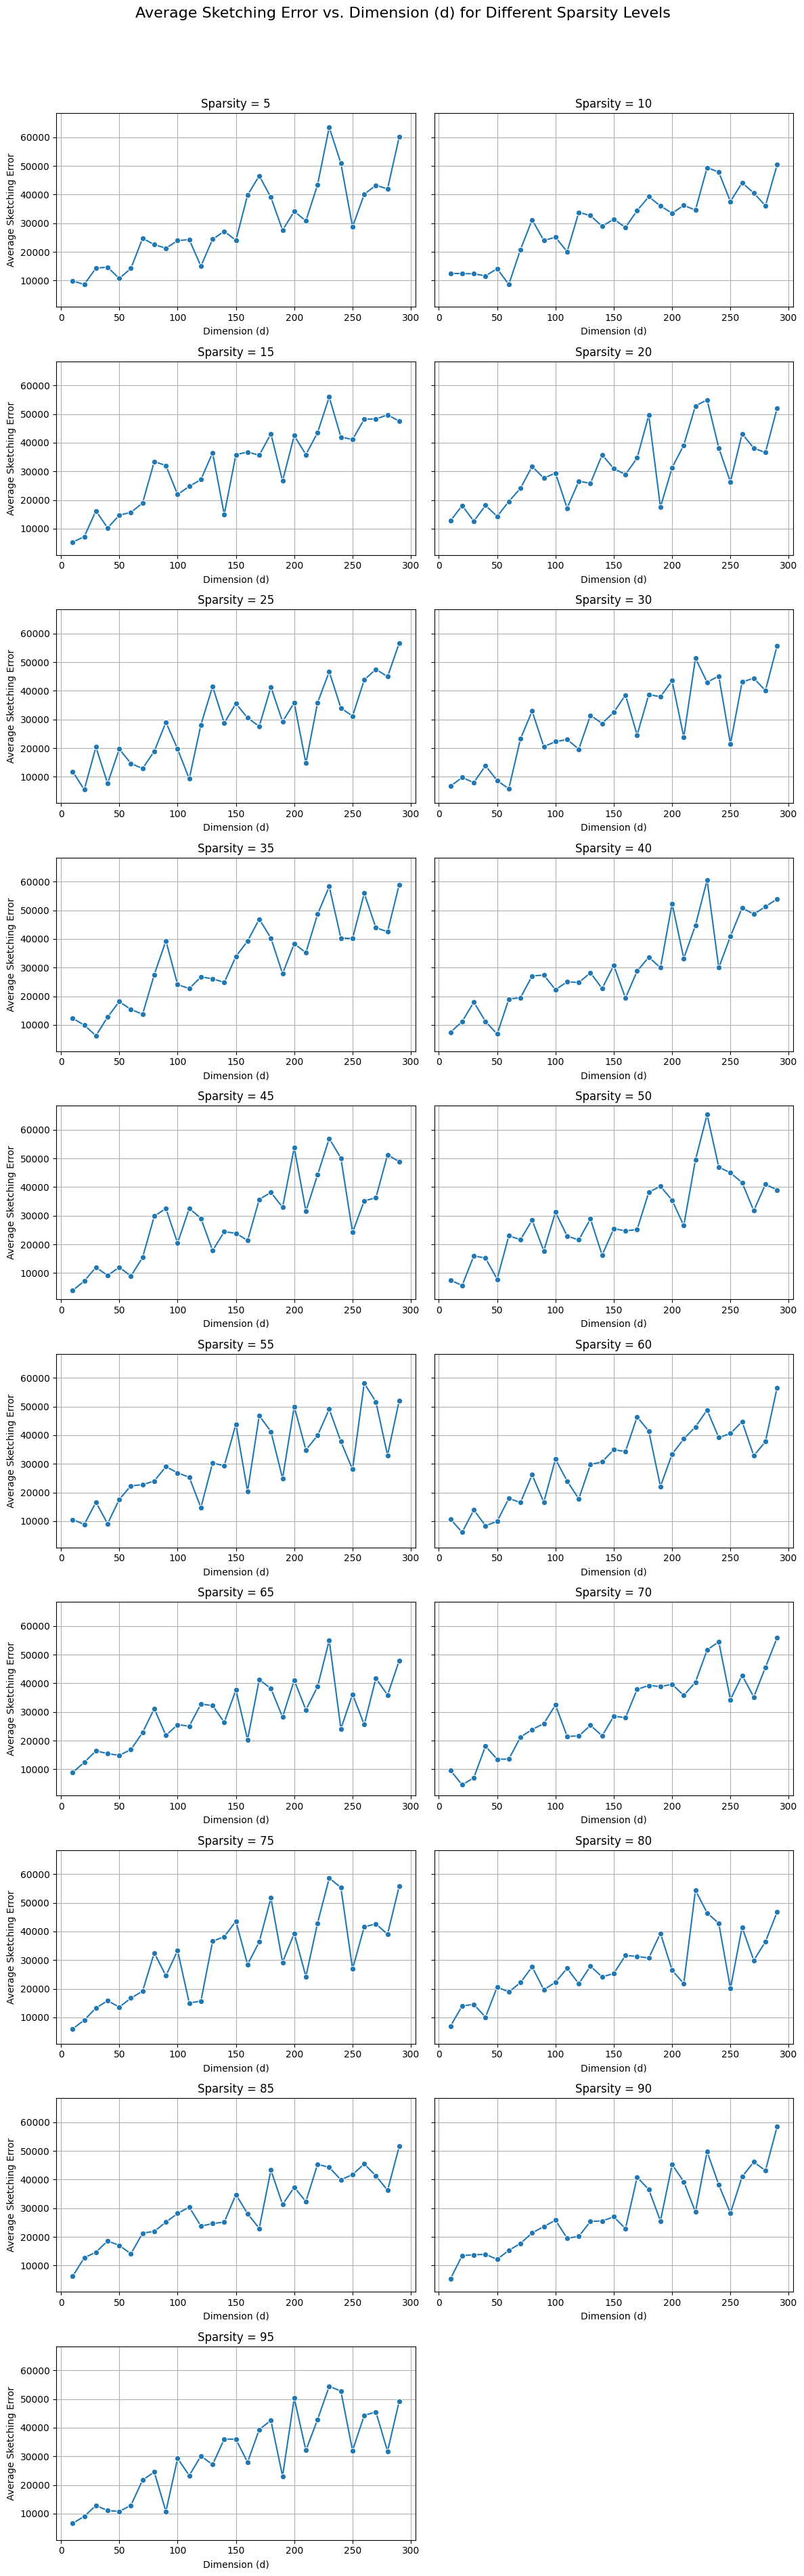

In [184]:
sparsities = results_df['sparsity'].unique()


# 3. Plotting the graphs
#   This creates a grid layout and defines how to layout the code.
num_cols = 2  # Number of plots per row
num_rows = (len(sparsities) + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# 4. Code to loop throught the values
for i, sparsity_value in enumerate(sparsities):
    # Filter the DataFrame for current sparsity value
    df_subset = results_df[results_df['sparsity'] == sparsity_value]

    # Plot d vs. avg_sketching_error.  Line plot as requested.  You can change marker.
    sns.lineplot(x='d', y='avg_sketching_error', data=df_subset, ax=axes[i], marker='o')

    # Set the title and labels for current subplot
    axes[i].set_title(f'Sparsity = {sparsity_value}')
    axes[i].set_xlabel('Dimension (d)')
    axes[i].set_ylabel('Average Sketching Error')
    axes[i].grid(True)  # Add gridlines for better readability

# Remove empty subplots if the number of plots is not a multiple of num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent titles from overlapping and give a bit of extra space
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Add a suptitle to the entire figure
plt.suptitle('Average Sketching Error vs. Dimension (d) for Different Sparsity Levels', fontsize=16)

# Show the plot
plt.show()

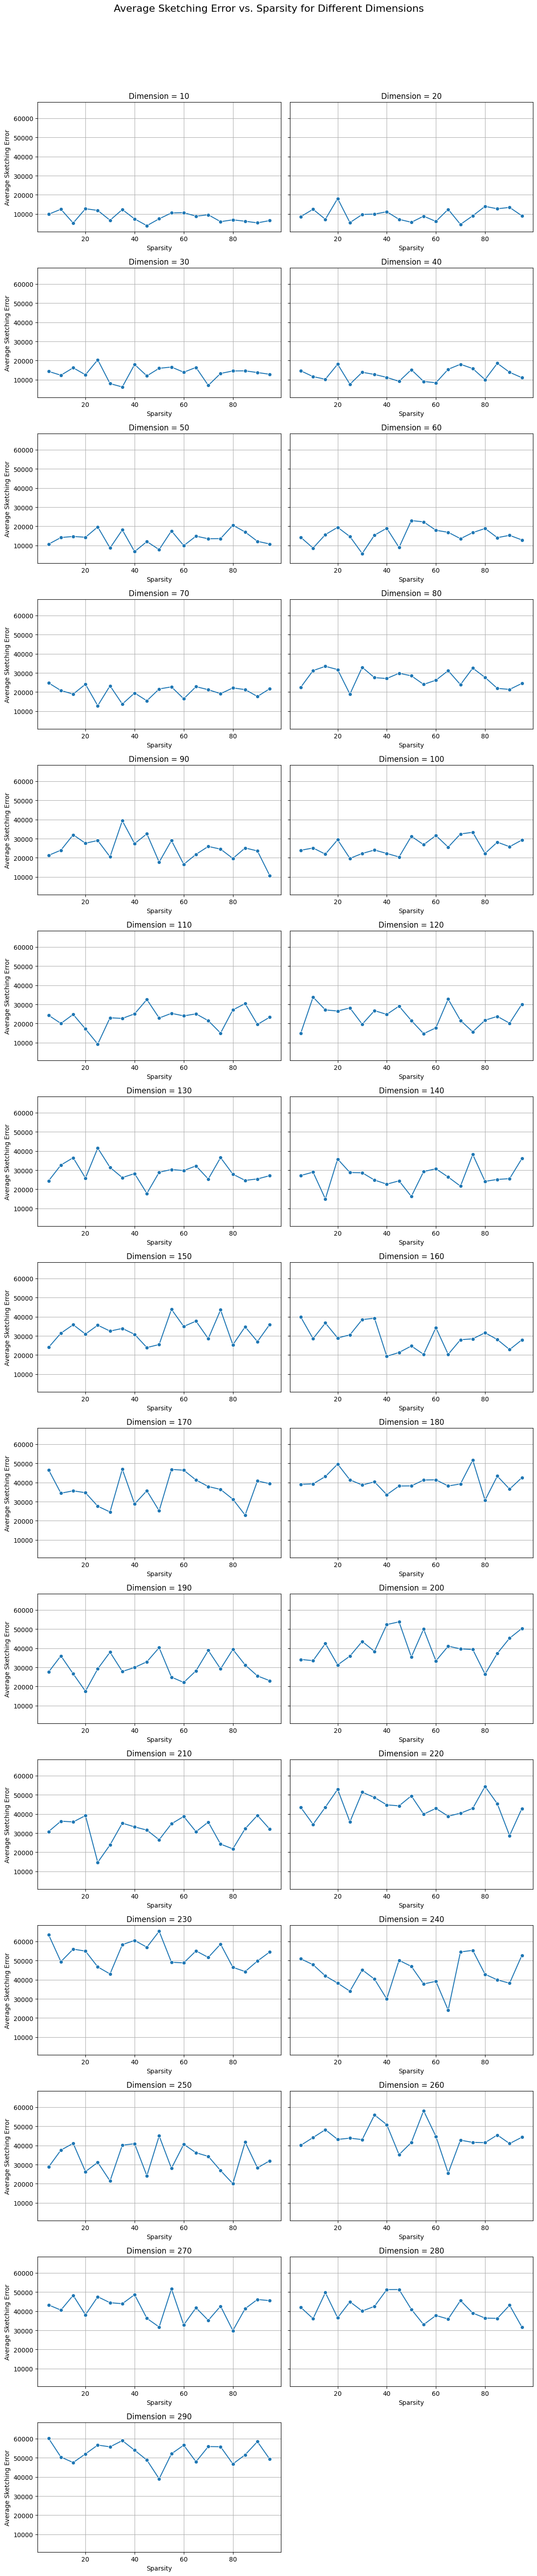

In [185]:
# Define the dimensions you want to plot
dimensions = results_df['d'].unique()

# Plotting the graphs
num_cols = 2  # Number of plots per row
num_rows = (len(dimensions) + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, dimension_value in enumerate(dimensions):
    # Filter the DataFrame for the current dimension value
    df_subset = results_df[results_df['d'] == dimension_value]

    # Plot sparsity vs. avg_sketching_error.  Line plot as requested.  You can change the marker.
    sns.lineplot(x='sparsity', y='avg_sketching_error', data=df_subset, ax=axes[i], marker='o')

    # Set the title and labels for the current subplot
    axes[i].set_title(f'Dimension = {dimension_value}')
    axes[i].set_xlabel('Sparsity')
    axes[i].set_ylabel('Average Sketching Error')
    axes[i].grid(True)  # Add gridlines for better readability

# Remove empty subplots if the number of plots is not a multiple of num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent titles from overlapping and give a bit of extra space
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Add a suptitle to the entire figure
plt.suptitle('Average Sketching Error vs. Sparsity for Different Dimensions', fontsize=16)

# Show the plot
plt.show()

SGD test

In [15]:
n = 100000 # Number of samples
d = 50   # Number of features
m=2000
condition_number = 1e16

# Generate problem
A, b, x_true = generate_ill_conditioned_problem_svd(n, d, condition_number)

In [23]:
x, intercept, qr_time, iteration_times, total_time = fast_least_squares_sgd_with_intercept_no_sketch(A, b)
y_pred = A @ x + intercept
mse = mean_squared_error(y_pred, b)
print(f"QR Decomposition Time: {qr_time:.6f} seconds")
print(f"Total SGD Time: {sum(iteration_times):.6f} seconds")
print(f"Total Algorithm Time: {total_time:.6f} seconds")
print(f"Mean Squared Error: {mse:.6e}")

QR Decomposition Time: 0.493885 seconds
Total SGD Time: 4.016384 seconds
Total Algorithm Time: 5.004661 seconds
Mean Squared Error: 6.873166e-02


In [24]:
x, intercept, qr_time, iteration_times,sketching_time, total_time = fast_least_squares_sgd_analysis(A, b, m)
y_pred = A @ x + intercept
mse = mean_squared_error(y_pred, b)
print(f"QR Decomposition Time: {qr_time:.6f} seconds")
print(f"Total SGD Time: {sum(iteration_times):.6f} seconds")
print(f"Total Sketch Time: {sketching_time:.6f} seconds")
print(f"Total Algorithm Time: {total_time:.6f} seconds")
print(f"Mean Squared Error: {mse:.6e}")

(51, 51)
QR Decomposition Time: 0.024621 seconds
Total SGD Time: 4.161260 seconds
Total Sketch Time: 0.019090 seconds
Total Algorithm Time: 4.702897 seconds
Mean Squared Error: 4.485888e-02


In [25]:
sparsity = 5
x, intercept, qr_time, iteration_times,sketching_time, total_time = sketch_least_squares_sgd_analysis(A, b, m, sparsity)
y_pred = A @ x + intercept
mse = mean_squared_error(y_pred, b)
print(f"QR Decomposition Time: {qr_time:.6f} seconds")
print(f"Total SGD Time: {sum(iteration_times):.6f} seconds")
print(f"Total Sketch Time: {sketching_time:.6f} seconds")
print(f"Total Algorithm Time: {total_time:.6f} seconds")
print(f"Mean Squared Error: {mse:.6e}")

(51, 51)
QR Decomposition Time: 0.000000 seconds
Total SGD Time: 3.747952 seconds
Total Sketch Time: 6.245392 seconds
Total Algorithm Time: 10.434446 seconds
Mean Squared Error: 3.918323e-02


Iteration 10 and avg the results

In [65]:
n = 10000 # Number of samples
d = 50  # Number of features
m=200
condition_number = 1e18

# Generate problem
A, b, x_true = generate_ill_conditioned_problem_svd(n, d, condition_number)

In [66]:
# Initialize list to store results
results = []

n_runs = 10

for run in range(n_runs):
    # Run one iteration of the algorithm
    x, intercept, qr_time, iteration_times, total_time = fast_least_squares_sgd_with_intercept_no_sketch(A, b)
    
    # Calculate predictions and MSE
    y_pred = A @ x + intercept
    mse = mean_squared_error(y_pred, b)
    
    # Store results
    results.append({
        'Run': run + 1,
        'QR Time': qr_time,
        'SGD Time': sum(iteration_times),
        'Total Time': total_time,
        'MSE': mse,
        'Iterations': len(iteration_times)
    })

# Create DataFrame
non_sketch_ill_10_df = pd.DataFrame(results)

In [67]:
avg_non_sketch_ill_10_df = non_sketch_ill_10_df.mean()
avg_non_sketch_ill_10_df

Run              5.500000
QR Time          0.037954
SGD Time         0.134517
Total Time       0.222654
MSE              0.026462
Iterations    1000.000000
dtype: float64

In [68]:
# Initialize list to store results
results = []

n_runs = 10

for run in range(n_runs):
    # Run one iteration of the algorithm
    x, intercept, qr_time, iteration_times,sketching_time, total_time = fast_least_squares_sgd_analysis(A, b, m)
    
    # Calculate predictions and MSE
    y_pred = A @ x + intercept
    mse = mean_squared_error(y_pred, b)
    
    # Store results
    results.append({
        'Run': run + 1,
        'QR Time': qr_time,
        'SGD Time': sum(iteration_times),
        'Sketch Time': sketching_time,
        'Total Time': total_time,
        'MSE': mse,
        'Iterations': len(iteration_times)
    })

# Create DataFrame
fast_sketch_ill_10_df = pd.DataFrame(results)

In [69]:
avg_fast_sketch_ill_10_df = fast_sketch_ill_10_df.mean()
avg_fast_sketch_ill_10_df

Run               5.500000
QR Time           0.011489
SGD Time          0.130531
Sketch Time       0.001259
Total Time        0.190163
MSE               0.019791
Iterations     1000.000000
dtype: float64

In [70]:
# Initialize list to store results
results = []
sparsity = 10
n_runs = 10

for run in range(n_runs):
    # Run one iteration of the algorithm
    
    x, intercept, qr_time, iteration_times,sketching_time, total_time = sketch_least_squares_sgd_analysis(A, b, m, sparsity)
    
    # Calculate predictions and MSE
    y_pred = A @ x + intercept
    mse = mean_squared_error(y_pred, b)
    
    # Store results
    results.append({
        'Run': run + 1,
        'QR Time': qr_time,
        'SGD Time': sum(iteration_times),
        'Sketch Time': sketching_time,
        'Total Time': total_time,
        'MSE': mse,
        'Iterations': len(iteration_times)
    })

# Create DataFrame
sketch_ill_10_df = pd.DataFrame(results)

In [71]:
avg_sketch_ill_10_df = sketch_ill_10_df.mean()
avg_sketch_ill_10_df

Run               5.500000
QR Time           0.008316
SGD Time          0.120998
Sketch Time       0.313412
Total Time        0.484244
MSE               0.111439
Iterations     1000.000000
dtype: float64